In [1]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import polars as pl
import itertools
import warnings
from scipy.sparse import csr_matrix
from textwrap import wrap

import pandas as pd
import statsmodels.api as sm 

sns.set(style="darkgrid", palette="Set2", context="paper")
warnings.filterwarnings(action='ignore')

In [2]:
# dont ignore the first line of the csv files. Keep variable as np array

def read_names(file_path):
    return np.genfromtxt(file_path, dtype=str, delimiter="\n")

unwrapped_complex_names = read_names("data/complex_names.txt")
unwrapped_monomer_names = read_names("data/protein_names.txt")
unwrapped_cofactor_names = read_names("data/cofactor_names.txt")
unwrapped_element_names = read_names("data/element_ids.txt")
unwrapped_pathway_names = read_names("data/pathway_names.txt")


complex_ids = read_names("data/complex_ids.txt")
monomer_ids = read_names("data/protein_ids.txt")
cofactor_ids = read_names("data/cofactor_ids.txt")
element_ids = read_names("data/element_ids.txt")
pathway_ids = read_names("data/pathway_ids.txt")
aa_ids = read_names("data/amino_acid_ids.txt")

unwrapped_protein_names = np.concatenate([unwrapped_complex_names, unwrapped_monomer_names])
protein_ids = np.concatenate([complex_ids, monomer_ids])

# Reading the matrix CSV files
def read_matrix(file_path, sparse=False):
    # add sparse matrix reading
    if sparse:
        return csr_matrix(pl.read_csv(file_path, has_header=False).to_numpy())
    else:
        return pl.read_csv(file_path, has_header=False).to_numpy()

C = read_matrix("data/C_matrix.csv", sparse=True)
P = read_matrix("data/P_matrix.csv", sparse=True)
E = read_matrix("data/E_matrix.csv", sparse=True)
W = read_matrix("data/W_matrix.csv", sparse=True)
W2 = read_matrix("data/W2_matrix.csv", sparse=True)
W1 = read_matrix("data/W1_matrix.csv", sparse=True)
A = read_matrix("data/A_matrix.csv")
Tree = read_matrix("data/tree_matrix.csv", sparse=True)

total_counts_min = read_matrix("data/counts.csv")
total_counts = read_matrix("data/rich_counts.csv")
total_counts_anaero = read_matrix("data/anaerobic_counts.csv")
total_counts_big = read_matrix("data/rich_counts_big.csv")

monomer_masses = read_matrix("data/monomer_masses.csv").flatten()
monomer_areas = read_matrix("data/monomer_areas.csv").flatten()
complex_areas = read_matrix("data/complex_areas.csv").flatten()
protein_areas = np.concatenate([complex_areas, monomer_areas])

# Validation against 2001 ICP-MS data

## Export data for Mia for data comparison

In [3]:
elements = ["FE", "ZN", "MN", "CU", "MO", "NI", "CO"]
element_indices = [np.where(element_ids == element)[0][0] for element in elements]

# compute the timeseries for the elements
big_element_timeseries = total_counts_big[:, 1:-1] @ C @ P @ E[:, element_indices]

# convert to polars dataframe
big_element_df = pl.DataFrame(big_element_timeseries, schema=elements)

# add Timestep and Cell index from total_counts_big 
big_element_df = big_element_df.with_columns(pl.DataFrame(total_counts_big[:, [0, -1]], schema=["Timestep", "Cell index"]))
big_element_df

# Groupby cell index, then add the max timestep for each cell
max_timestep = big_element_df.group_by("Cell index").agg(pl.col("Timestep").max().alias("Max timestep"))

# merge with original
big_element_df = big_element_df.join(max_timestep, on="Cell index")

# calculate cell density correction factor with 2 ^((Max timestep - Timestep)/Max timestep)
big_element_df = big_element_df.with_columns( (2 ** ((big_element_df["Max timestep"] - big_element_df["Timestep"]) 
                                                     / big_element_df["Max timestep"])).alias("Density correction"))

# remove all cols except element, cell index and density correction
big_element_df = big_element_df.drop(["Timestep", "Max timestep"])

# multiply the atoms/cell by the density correction
big_element_df = big_element_df.melt(id_vars=["Cell index", "Density correction"], value_name="Atoms/cell", variable_name="Element")

# Get the weighted average per element
big_element_df = big_element_df.with_columns( (big_element_df["Atoms/cell"] * big_element_df["Density correction"]).alias("Weighted atoms/cell"))

# divide sum of weighted atoms/cell by sum of density correction
bulk_element_sum = big_element_df.group_by(["Element", "Cell index"]).agg(pl.sum("Weighted atoms/cell").alias("Sum weighted atoms/cell"))
bulk_element_count = big_element_df.group_by(["Element", "Cell index"]).agg(pl.sum("Density correction").alias("Sum density correction"))

# join the two dataframes and divide
bulk_element_df = bulk_element_sum.join(bulk_element_count, on=["Element", "Cell index"])
bulk_element_df = bulk_element_df.with_columns( (bulk_element_df["Sum weighted atoms/cell"] / bulk_element_df["Sum density correction"]).alias("Bulk atoms/cell"))

# remove other cols
bulk_element_df = bulk_element_df.drop(["Sum weighted atoms/cell", "Sum density correction"])

# save to csv
bulk_element_df.write_csv("data/sim_rich_bulk_element_df.csv", include_header=True)

# calculate avg and std dev over all cells
bulk_element_avg = bulk_element_df.group_by("Element").agg(pl.mean("Bulk atoms/cell").alias("Avg atoms/cell"), pl.std("Bulk atoms/cell").alias("Std atoms/cell"))

# add two rows: V and CR with 0 atoms/cell. Concat them to bulk_element_avg
bulk_element_avg = pl.concat([bulk_element_avg, pl.DataFrame([["V", 0., 0.], ["CR", 0., 0.]], schema=["Element", "Avg atoms/cell", "Std atoms/cell"])])

# set "CO" to 0
bulk_element_avg = bulk_element_avg.with_columns(pl.when(pl.col("Element") == "CO").then(0).otherwise(pl.col("Avg atoms/cell")).alias("Avg atoms/cell"))
bulk_element_avg = bulk_element_avg.with_columns(pl.when(pl.col("Element") == "CO").then(0).otherwise(pl.col("Std atoms/cell")).alias("Std atoms/cell"))

bulk_element_avg

Element,Avg atoms/cell,Std atoms/cell
str,f64,f64
"""NI""",1349.451218,202.649004
"""MO""",3642.138596,346.19631
"""MN""",70715.579385,3175.616962
"""FE""",439779.010905,24899.6101
"""ZN""",358309.796049,17700.748347
"""CU""",19175.295716,1318.540353
"""CO""",0.0,0.0
"""V""",0.0,0.0
"""CR""",0.0,0.0


# Expor table of interactions for Mia for overlaying on protein count comparison

In [4]:
elements = ["FE", "ZN", "MN", "CU", "MO", "NI", "CO"]
element_indices = [np.where(element_ids == element)[0][0] for element in elements]

# compute the timeseries for the elements
interaction_matrix = C @ P @ E[:, element_indices]

# create dataframe 
interaction_df = pl.DataFrame(interaction_matrix.toarray(), schema=elements)

# add protein ids as a column
interaction_df = interaction_df.with_columns(pl.DataFrame(protein_ids, schema=["Protein ID"]))

# save to csv
interaction_df.write_csv("data/interaction_df.csv", include_header=True)

interaction_df

FE,ZN,MN,CU,MO,NI,CO,Protein ID
i64,i64,i64,i64,i64,i64,i64,str
0,0,0,0,0,0,0,"""1-PFK"""
0,0,0,0,0,0,0,"""2OXOGLUTARATEDEH-CPLX"""
0,0,0,0,0,0,0,"""3-ISOPROPYLMALDEHYDROG-CPLX"""
4,0,0,0,0,0,0,"""3-ISOPROPYLMALISOM-CPLX"""
0,0,0,0,0,0,0,"""3-METHYL-2-OXOBUT-OHCH3XFER-CP…"
…,…,…,…,…,…,…,…
0,0,0,0,0,0,0,"""YTFR-MONOMER"""
0,0,0,0,0,0,0,"""YTFT-MONOMER"""
0,1,0,0,0,0,0,"""ZNUA-MONOMER"""


## Retrieve validation data

In [5]:
elements = ["FE", "ZN", "MN", "CU", "MO", "NI", "CO", "V", "CR"]

val_orig_df = pl.read_csv('external_data/distances.csv')

val_orig_df = val_orig_df.with_columns((   (-9* ( 1 - pl.col("Distance") / pl.col("ScaleDist")))  ).alias("Log concentration"))
val_orig_df = val_orig_df.with_columns(   (10**(pl.col("Log concentration"))).alias("Concentration (M)")  )
val_orig_df = val_orig_df.with_columns( (pl.col("Concentration (M)") *  (10**pl.col("ScaleCounts")) ).alias("Atoms/cell"))
val_orig_df

# filter out the elements
val_df = val_orig_df.filter(pl.col("Element").is_in(elements) & pl.col("Cell") == True)

# val_df = val_df.filter(pl.col("Condition") == "Rich")

val_df.write_csv("data/val_df.csv", include_header=True)

## Estimate upper limit of atoms/cell available in media

In [6]:
media_lim_df = val_orig_df.filter(pl.col("Cell") == False).drop(["Error", "Distance", "ScaleDist", "ScaleCounts"])
# media_lim_df = media_lim_df.filter(pl.col("Condition") == "Rich")

# to convert from atoms/cell in media, take the concentration in the media, convert to atoms by mult w avo, then divide by 3e11 cells per L
media_lim_df = media_lim_df.with_columns( (pl.col("Concentration (M)") * 6.022e23 / 3.5e11).alias("Atoms/cell"))

media_lim_df.to_pandas()

,Condition,BelowLOD,Cell,Element,Log concentration,Concentration (M),Atoms/cell
0,Minimal,0,0,MO,-7.730374,1.860483e-08,3.201094e+04
1,Minimal,0,0,SE,-7.548822,2.826037e-08,4.862399e+04
2,Minimal,0,0,ZN,-6.903050,1.250115e-07,2.150911e+05
3,Minimal,0,0,CU,-7.208921,6.181290e-08,1.063535e+05
4,Minimal,0,0,NI,-7.707702,1.960187e-08,3.372642e+04
5,Minimal,1,0,CO,-8.342515,4.544486e-09,7.819112e+03
6,Minimal,1,0,FE,-6.460629,3.462353e-07,5.957225e+05
7,Minimal,0,0,MN,-7.685031,2.065235e-08,3.553384e+04
8,Minimal,0,0,CR,-6.687467,2.053679e-07,3.533501e+05
9,Minimal,0,0,V,-7.707504,1.961085e-08,3.374187e+04


## Import EZ rich composition

In [7]:
ez_df = pl.read_csv('external_data/ez_media_concentrations.csv')

# convert µM to molar
ez_df = ez_df.with_columns( (ez_df["Concentration (µM)"] * 1e-6).alias("Concentration (M)")  )

# convert to atoms/cell assuming 8.0 * 10^8 cells per L
ez_df = ez_df.with_columns( (ez_df["Concentration (M)"] * 6.022e23 / 2e11).alias("Atoms/cell")  )

# Set Zn to 0 since it's unreliable due to contamination
# ez_df = ez_df.with_columns(pl.when(pl.col("Element") == "ZN").then(-500000).otherwise(pl.col("Atoms/cell")).alias("Atoms/cell"))

ez_df

Condition,Element,Concentration (raw),Concentration (µM),Concentration (M),Atoms/cell
str,str,str,f64,f64,f64
"""Minimal""","""FE""","""10 µM""",10.0,0.00001,3.011e7
"""Minimal""","""MN""","""80 nM""",0.08,8.0000e-8,240880.0
"""Minimal""","""CO""","""30.0 nM""",0.03,3.0000e-8,90330.0
"""Minimal""","""ZN""","""10 nM""",0.01,1.0000e-8,30110.0
"""Minimal""","""CU""","""10 nM""",0.01,1.0000e-8,30110.0
…,…,…,…,…,…
"""Rich""","""CO""","""30.0 nM""",0.03,3.0000e-8,90330.0
"""Rich""","""ZN""","""10 nM""",0.01,1.0000e-8,30110.0
"""Rich""","""CU""","""10 nM""",0.01,1.0000e-8,30110.0


## Final rich plot

In [8]:
rich_exp_caption = "Experiment, LB rich media"
rich_sim_caption = "Simulation, EZ rich media"
minimal_exp_caption = "Experiment, M9 minimal media"
minimal_sim_caption = "Simulation, MOPS minimal media"

figure_height = 3

In [9]:
elements = ["FE", "ZN", "MN", "CU", "MO", "NI", "CO", "V", "CR"]

val_comparison = val_df.filter((pl.col("Condition") == "Rich") & pl.col("Element").is_in(elements))

# Get Element and Atoms/cell columns
val_comparison = val_comparison.select(["Element", "Atoms/cell", "Error"])

# rename Error to Std dev
val_comparison = val_comparison.rename({"Error": "Atoms/cell (experiment), stddev", "Atoms/cell": "Atoms/cell (experiment)"})
bulk_element_avg = bulk_element_avg.rename({"Avg atoms/cell": "Atoms/cell (simulation)", "Std atoms/cell": "Atoms/cell (simulation), stddev"})



In [10]:
# add a column with the source of the data
# val_comparison = val_comparison.with_columns(pl.lit("Experiment").alias("Source"))
# bulk_element_avg = bulk_element_avg.with_columns(pl.lit("Simulation").alias("Source"))

# join two dataframes on element. left name is (Simulation) right name is (Experiment)
final_df = val_comparison.join(bulk_element_avg, on="Element")

final_df

Element,Atoms/cell (experiment),"Atoms/cell (experiment), stddev",Atoms/cell (simulation),"Atoms/cell (simulation), stddev"
str,f64,f64,f64,f64
"""NI""",3240.269333,1000.0,1349.451218,202.649004
"""MO""",10797.032626,1000.0,3642.138596,346.19631
"""MN""",46743.626407,12922.173275,70715.579385,3175.616962
"""FE""",607143.184501,128046.989721,439779.010905,24899.6101
"""ZN""",399640.415582,88105.726872,358309.796049,17700.748347
"""CU""",87576.66829,29368.575624,19175.295716,1318.540353
"""CO""",443.558908,100.0,0.0,0.0
"""V""",249.432594,1000.0,0.0,0.0
"""CR""",3414.351358,1000.0,0.0,0.0


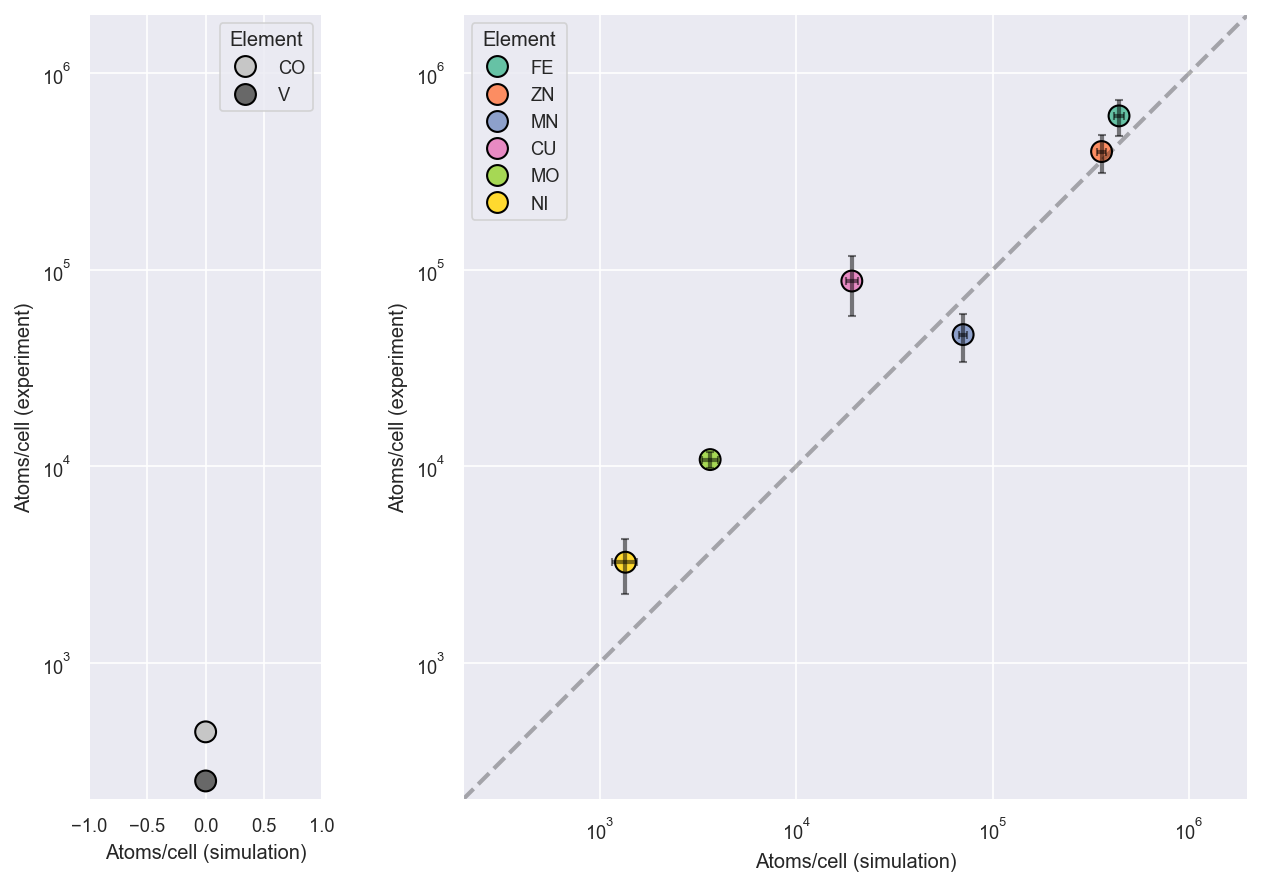

In [11]:


# create pointplot with error bars
f, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 4]}, figsize=[9,6] )


elements = ["V", "CO"]
sns.scatterplot(data=final_df.filter(pl.col("Element").is_in(elements)).to_pandas(), x="Atoms/cell (simulation)", y="Atoms/cell (experiment)", 
                 s=100, ax=ax[0], hue= "Element", palette="Greys", edgecolor='black', linewidth=1)

ax[0].set_yscale("log")
ax[0].set_xlim(-1, 1)
ax[0].set_ylim(200, 2*10**6)


elements = ["FE", "ZN", "MN", "CU", "MO", "NI"]

filter_df = final_df.filter(pl.col("Element").is_in(elements))

sns.scatterplot(data=filter_df.to_pandas(), x="Atoms/cell (simulation)", y="Atoms/cell (experiment)", hue="Element", hue_order=elements, s=100, ax=ax[1], edgecolor='black', linewidth=1)
    

# add error bars
for i in range(filter_df.shape[0]):
    ax[1].errorbar(filter_df["Atoms/cell (simulation)"][i], 
                   filter_df["Atoms/cell (experiment)"][i], 
                 xerr=filter_df["Atoms/cell (simulation), stddev"][i], yerr=filter_df["Atoms/cell (experiment), stddev"][i], 
                 color='black', alpha=0.5, capsize=2, capthick=1, elinewidth=2)


# log scale
ax[1].set_xscale("log")
ax[1].set_yscale("log")

# axis range from 100 to 10^6
ax[1].set_xlim(200, 2*10**6)
ax[1].set_ylim(200, 2*10**6)

# make both axes equal
plt.gca().set_aspect('equal', adjustable='box')

# create a x=y line 
ax[1].plot([200, 2*10**6], [200, 2*10**6], color='black', linestyle='--', alpha=0.3, linewidth=2)

f.tight_layout()

# Repeat analysis for minimal media

|# Add biologically unnecessary trace elements 

# Single-cell data

In [12]:
elements = ["FE", "ZN", "MN", "CU", "MO", "NI", "CO"]
element_indices = [np.where(element_ids == element)[0][0] for element in elements]

sc_df = pl.read_csv('external_data/single_cell_fe.csv')

# remove the first row
# sc_df = sc_df.filter((pl.col("Bin") > 16) & (pl.col("Bin") < 60))

# create 1d list of all bins with comprehension
bins = sc_df["Bin"].to_numpy()
counts = sc_df["Count"].to_numpy()

# create a list with bin value repeated counts times
real_hist_data = np.repeat(bins, counts)

In [13]:
# compute the timeseries for the elements
big_element_timeseries = total_counts_big[:, 1:-1] @ C @ P @ E[:, element_indices]

# convert to polars dataframe
big_element_df = pl.DataFrame(big_element_timeseries, schema=elements)

# add Timestep and Cell index from total_counts_big 
big_element_df = big_element_df.with_columns(pl.DataFrame(total_counts_big[:, [0, -1]], schema=["Timestep", "Cell index"]))
big_element_df

# Groupby cell index, then add the max timestep for each cell
max_timestep = big_element_df.group_by("Cell index").agg(pl.col("Timestep").max().alias("Max timestep"))

# merge with original
big_element_df = big_element_df.join(max_timestep, on="Cell index")

# calculate cell density correction factor with 2 ^((Max timestep - Timestep)/Max timestep)
big_element_df = big_element_df.with_columns( (2 ** ((big_element_df["Max timestep"] - big_element_df["Timestep"]) 
                                                     / big_element_df["Max timestep"])).alias("Density correction"))

# remove all cols except element, cell index and density correction
big_element_df = big_element_df.drop(["Timestep", "Max timestep"])

# multiply the atoms/cell by the density correction
big_element_df = big_element_df.melt(id_vars=["Cell index", "Density correction"], value_name="Atoms/cell", variable_name="Element")

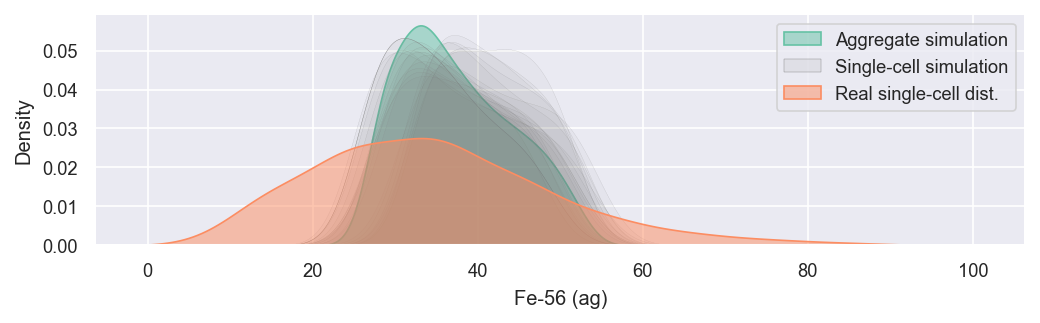

In [14]:
# filter FE 
big_fe_df = big_element_df.filter(pl.col("Element") == "FE")

# convert atoms/cell to float
big_fe_df = big_fe_df.with_columns( (big_fe_df["Atoms/cell"] * 55.85 * 10**18 * 0.92 / (6.023*10**23)).alias("Fe-56 (ag)"))

# create fig
plt.figure(figsize=(8, 2))

# create a weighted KDE plot 
sns.kdeplot(data=big_fe_df.to_pandas(), x="Fe-56 (ag)", weights="Density correction", fill=True, bw_adjust=2, label="Aggregate simulation", alpha=0.5)
# sns.histplot(data=big_fe_df.to_pandas(), x="Fe-56 (ag)", weights="Density correction",stat="density", binwidth=10, alpha=0.5, label="Aggregate sim")

# plot every cell from 0 to 18 with low alpha and gray color
for i in range(0, 18):
    if i == 1:
        sns.kdeplot(data=big_fe_df.filter(pl.col("Cell index") == i).to_pandas(), x="Fe-56 (ag)", 
                weights="Density correction", fill=True, bw_adjust=2, alpha=0.1, color="gray", linewidth=0.2, label="Single-cell simulation")
    else:
        sns.kdeplot(data=big_fe_df.filter(pl.col("Cell index") == i).to_pandas(), x="Fe-56 (ag)", 
                # weights="Density correction", 
                fill=True, bw_adjust=2, alpha=0.05, color="gray", linewidth=0.05)

# sns.kdeplot(data=big_fe_df.filter(pl.col("Cell index") == 10).to_pandas(), x="Fe-56 (ag)", 
#             weights="Density correction", fill=True, bw_adjust=2, label="Random cell 10")
# sns.kdeplot(data=big_fe_df.filter(pl.col("Cell index") == 3).to_pandas(), x="Fe-56 (ag)", 
#             weights="Density correction", fill=True, bw_adjust=2, label="Random cell 3")

# plot histogram data in sc_df, as lineplot with fill
sns.kdeplot(data=real_hist_data, fill=True, bw_adjust=1.3, label="Real single-cell dist.", alpha=0.5)
# sns.histplot(real_hist_data, element="step", stat="density", binwidth=10, alpha=0.3, label="Real single-cell dist.", binrange=(10, 90))

plt.legend()

# Scope of interactions

In [15]:
elements = ["FE", "ZN", "MN", "CU", "MO", "NI", "CO"]
element_indices = [np.where(element_ids == element)[0][0] for element in elements]

nonzero_cplx = np.array(((C @ P @ E)[:, element_indices].sum(axis=1) > 0)).flatten()

interaction_matrix = (C @ P @ E)[nonzero_cplx, :][:, element_indices].toarray()

interaction_matrix.sum(axis=1)

real_data = []

# for each row in the interaction matrix, add new list to real data. 
# for each column j in the row, add j to the list (value) times
for i, row in enumerate(interaction_matrix):
    cur_list = []
    for j, value in enumerate(row):
        cur_list.extend([j] * value)
        
    real_data.append(cur_list)

real_data = real_data[:100]

# count subitems for each item
subitem_counts = np.array([len(subitems) for subitems in real_data])

# get maximum length
max_subitems_per_item = max(subitem_counts)

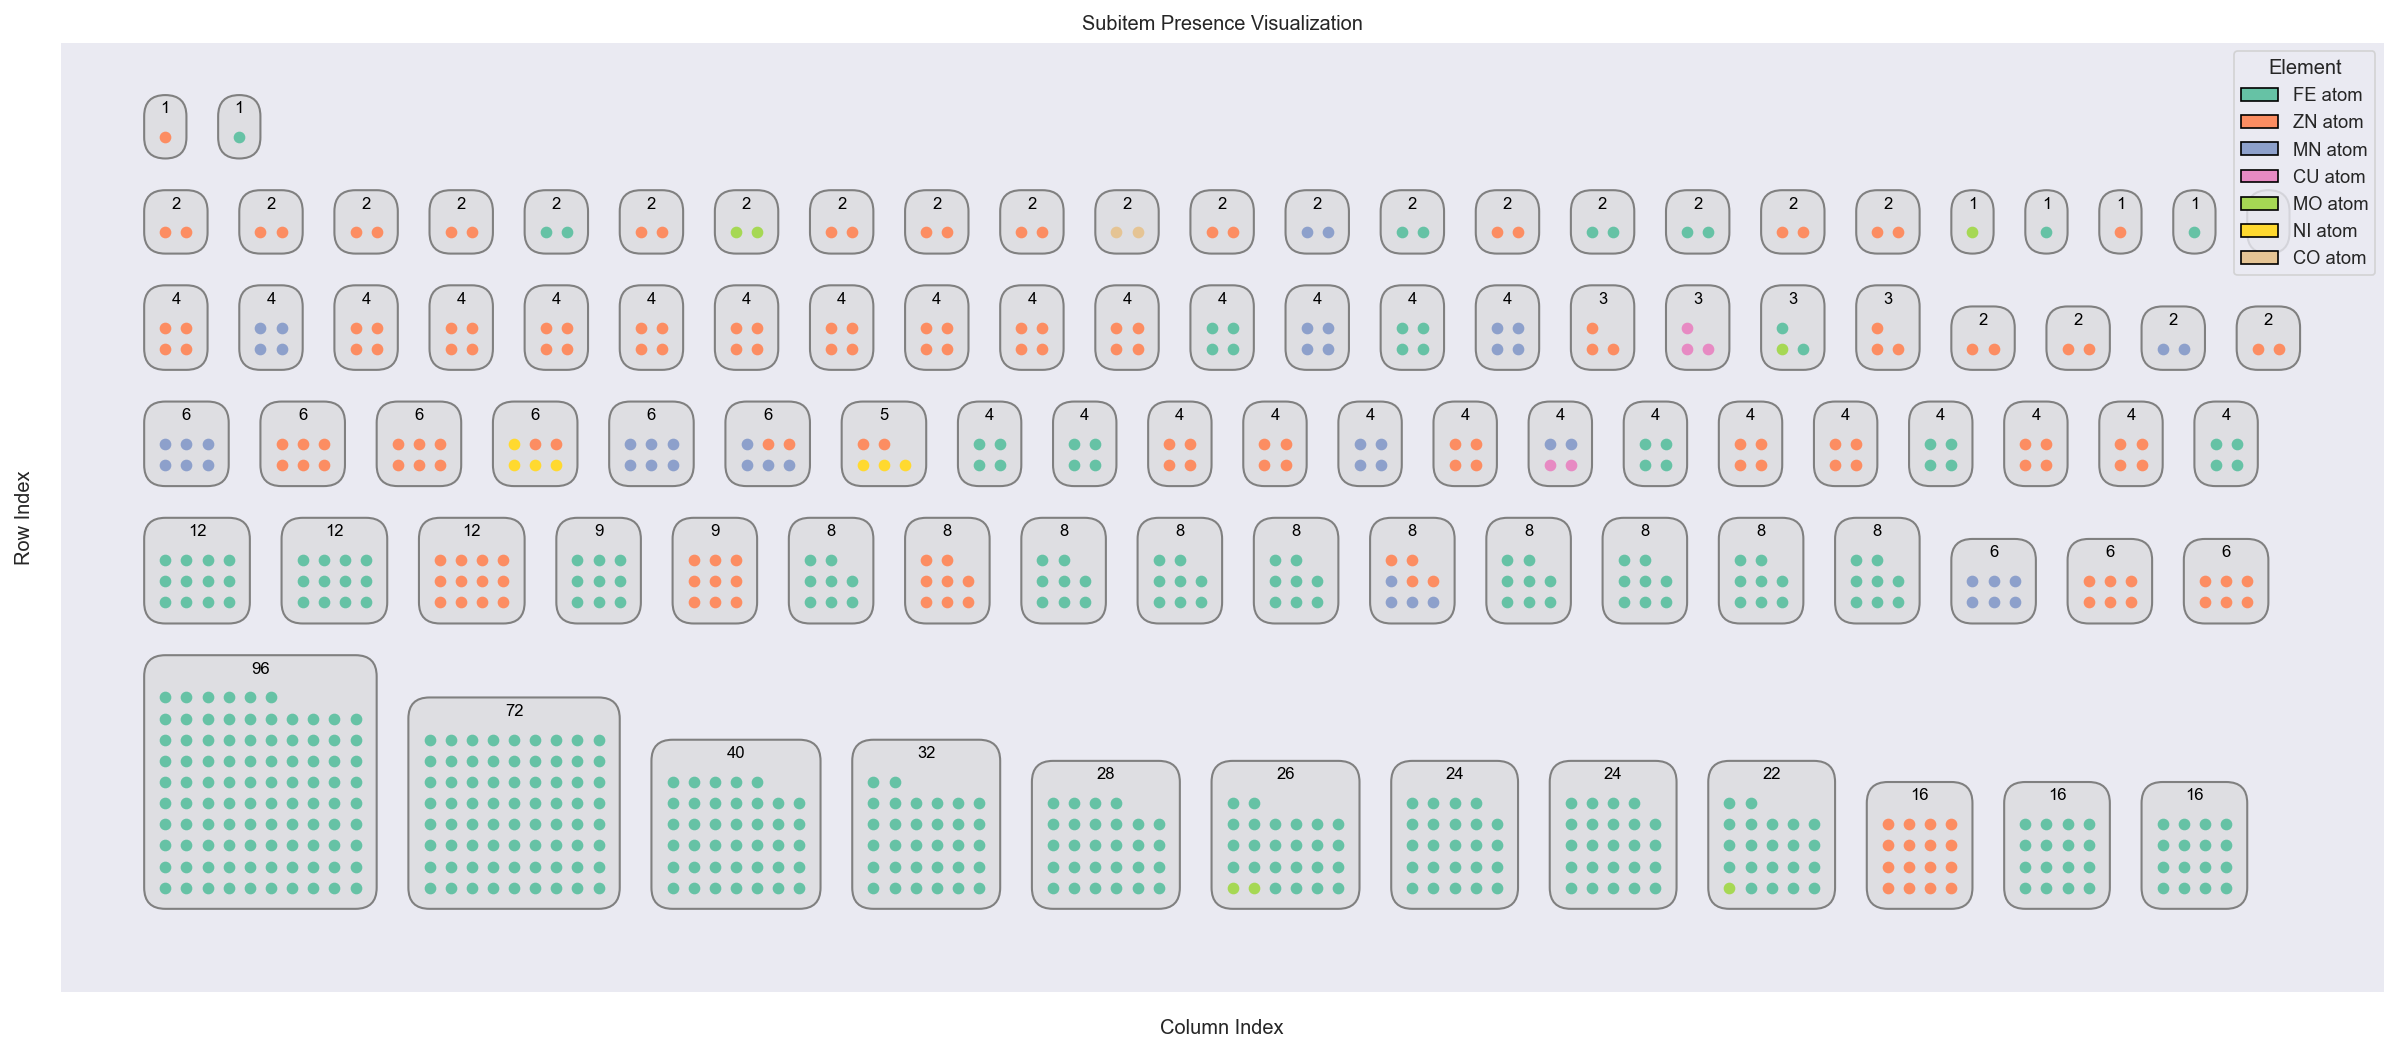

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches
from matplotlib.colors import to_rgba
import seaborn as sns


# Plotting
fig, ax = plt.subplots(figsize=(20, 20))

# Parameters
num_items = 100
max_subitems_per_item = 30
base_horizontal_spacing = 0.7  # Base spacing between items horizontally
base_vertical_spacing = 0.7  # Base vertical space between items
subitem_horizontal_spacing = 0.2  # Spacing between subitems horizontally
subitem_vertical_spacing = 0.2  # Spacing between subitems vertically
padding = 0.  # Padding around the bounding box

# Define color palette
palette = sns.color_palette("Set2", 7)

# Generating random number of subitems for each item
#subitem_counts = np.random.randint(1, max_subitems_per_item + 1, size=num_items)  # Each item has between 1 and 30 subitems

# Generating presence data for subitems with 4 possible values (0 to 3)
# data = [np.random.randint(0, 4, size=subitem_counts[i]) for i in range(num_items)]
data = real_data

# Sort the items first by the total number of subitems, then by the number of blue subitems (assuming 1 is blue)
sorted_indices = sorted(range(num_items), key=lambda i: (subitem_counts[i], np.sum(data[i] == 1)), reverse=True)
sorted_data = [data[i] for i in sorted_indices]
sorted_subitem_counts = subitem_counts[sorted_indices]

# Ensure subitems within each item are sorted by presence (in this case, value from 3 to 0)
sorted_data = [sorted(subitems, reverse=True) for subitems in sorted_data]


# Set equal scaling
ax.set_aspect('equal')

# Calculate required horizontal space for each item and subitems_per_line
item_widths = []
subitems_per_lines = []

for subitems in sorted_data:
    num_subitems = len(subitems)
    n = int(np.ceil(np.sqrt(num_subitems)))
    subitems_per_lines.append(n)
    item_widths.append(n * subitem_horizontal_spacing + padding * 2 - subitem_horizontal_spacing)

# Determine items per row dynamically based on their size
current_y_position = 0  # Track the current y position to space items vertically
current_x_position = 0  # Track the current x position to space items horizontally
row_height = 0  # Track the height of the current row

for item_idx, (subitems, num_subitems, item_width, subitems_per_line) in enumerate(zip(sorted_data, sorted_subitem_counts, item_widths, subitems_per_lines)):
    num_lines = (num_subitems + subitems_per_line - 1) // subitems_per_line  # Calculate the number of lines needed
    
    if current_x_position + item_width > 20:  # If adding this item exceeds the row width, move to the next row
        current_x_position = 0
        current_y_position += row_height + base_vertical_spacing
        row_height = 0  # Reset row height for the new row
    
    x_position = current_x_position
    y_position = current_y_position
    
    # Update row height if this item's height is greater
    row_height = max(row_height, num_lines * subitem_vertical_spacing + padding * 2)

    # Add text with the number of subitems above the subitems
    ax.text(x_position + item_width / 2, y_position + num_lines * subitem_vertical_spacing + padding * 1.5, f'{num_subitems}', va='bottom', ha='center', fontsize=8, color='black')
    
    # Draw rounded grey box with light grey background
    rect = patches.FancyBboxPatch(
        (x_position, y_position), item_width, num_lines * subitem_vertical_spacing + padding * 2, boxstyle="round,pad=0.2", linewidth=1, edgecolor='grey', facecolor=to_rgba('lightgrey', 0.5)
    )
    ax.add_patch(rect)

    # Plot each subitem in sorted order with wrapping
    for subitem_idx, presence in enumerate(subitems):
        line = subitem_idx // subitems_per_line
        position_in_line = subitem_idx % subitems_per_line
        color = palette[presence]
        ax.scatter(x_position + position_in_line * subitem_horizontal_spacing + padding, y_position + line * subitem_vertical_spacing + padding, color=color)
    


    # Update x position for the next item
    current_x_position += item_width + base_horizontal_spacing

# Labeling the plot
ax.set_xlabel('Column Index')
ax.set_ylabel('Row Index')
ax.set_title('Subitem Presence Visualization')

# Adjust the plot limits
ax.set_xlim(-1, 21)
ax.set_ylim(-1, current_y_position + row_height + base_vertical_spacing)

# remove xticklabels, yticklabels and grid
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.grid(False)

# make a legend. Each of the Set2 colors is a colored dot.
legend_elements = [patches.Patch(facecolor=palette[i], edgecolor='black', label=f'{elements[i]} atom') for i in range(7)]
ax.legend(handles=legend_elements, loc='upper right', title='Element')

plt.show()


In [17]:
fig.savefig("visual_metalloproteome.png")

## Generate table for Heena

In [18]:
# metal counts per protein

elements = ["FE", "ZN", "MN", "CU", "MO", "NI"]

element_indices = [np.where(element_ids == element)[0][0] for element in elements]

count_vec = total_counts[int(total_counts.shape[0]/2), :]

metalloprotein_matrix = np.diag(count_vec @ C) @ P @ E[:, element_indices]

# convert to dataframe
metalloprotein_df = pl.DataFrame(metalloprotein_matrix, schema=elements)

# add protein id column
metalloprotein_df = metalloprotein_df.with_columns(pl.DataFrame(monomer_ids, schema=["Protein ID"]))

# save to csv
metalloprotein_df.write_csv("data/metalloprotein_df.csv", include_header=True)

# Figure 2, general insights

## Resource comparison

In [19]:
elements = ["FE", "ZN"]
element_indices = [np.where(element_ids == element)[0][0] for element in elements]

aa = ["TRP", "GLY"]
aa_indices = [np.where(aa_ids == aa)[0][0] for aa in aa]

In [20]:
median_count = csr_matrix(np.diag(np.median(total_counts_min, axis=0)))

pe_counts = median_count @ C @ P @ E[:, element_indices]
paa_counts = (median_count @ C @ A[:, aa_indices])
pm_mass = median_count @ C * monomer_masses
resources = csr_matrix(np.stack([pe_counts[:, 0].toarray().flatten(), pe_counts[:, 1].toarray().flatten(), 
                                 paa_counts[:, 0].flatten(), paa_counts[:, 1].flatten(), pm_mass], axis=0))

# need to assign here to pathways
Pw = (C @ W @ W2) / (C @ W @ W2).sum(axis=1)

# multiply resources by Pw
Rp = resources @ Pw

In [21]:
wrapped_names = ["\n".join(wrap(text, 14)) for text in unwrapped_pathway_names]

# put in one array and convert to dataframe
resource_df = pl.DataFrame(Rp.toarray(), schema=elements + aa + ["Protein mass"])

# add protein ID column
resource_df = resource_df.with_columns(pl.DataFrame(wrapped_names, schema=["Pathway"]))

# melt df 
resource_df = resource_df.melt(value_name="Value", variable_name="Resource", id_vars="Pathway")

# groupby resource and get the sum
sum_df = resource_df.group_by("Resource").agg(pl.sum("Value").alias("Total"))

# join with resource_df to get the percentage
resource_df = resource_df.join(sum_df, on="Resource")
resource_df = resource_df.with_columns( (resource_df["Value"] / resource_df["Total"]).alias("Fraction"))

# drop zero value rows
resource_df = resource_df.filter(pl.col("Value") > 0)

# groupby pathway and get the sum of fraction
sum_f_df = resource_df.group_by("Pathway").agg(pl.sum("Fraction").alias("Sum of resource fractions"))

# join with resource_df to get the percentage
resource_df = resource_df.join(sum_f_df, on="Pathway")

# drop rows with Sum of resource fractions < 0.1
resource_df_f = resource_df.filter(pl.col("Sum of resource fractions") > 0.15)


([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, 'Translation'),
  Text(1, 0, 'Uncategorized'),
  Text(2, 0, 'Cofactor,\nCarrier, and\nVitamin\nBiosynthesis'),
  Text(3, 0, 'Amino Acid\nBiosynthesis'),
  Text(4, 0, 'Electron\nTransfer\nChains'),
  Text(5, 0, 'Regulation of\ntranscription'),
  Text(6, 0, 'TCA cycle'),
  Text(7, 0, 'Nucleoside and\nNucleotide\nBiosynthesis')])

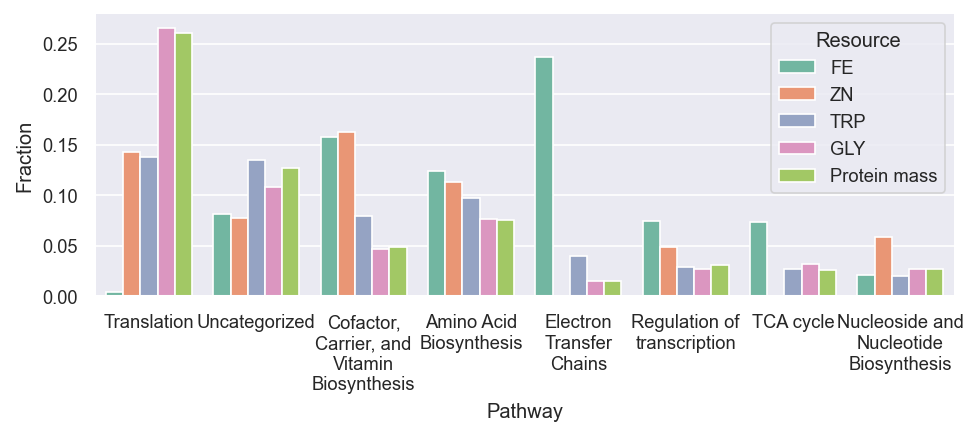

In [22]:
pw_order = resource_df_f.filter(pl.col("Resource") == "FE").sort("Sum of resource fractions", descending=True).select("Pathway").to_series().to_list()

sns.catplot(x="Pathway", y="Fraction", hue="Resource", data=resource_df.to_pandas(), kind="bar", aspect=2.2, height=3, order=pw_order, legend_out=False)

# rotate labels
plt.xticks(rotation=0)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [Text(0, 0, 'G6763-MONOMER'),
  Text(1, 0, 'CPLX0-7747'),
  Text(2, 0, 'EG10308-MONOMER'),
  Text(3, 0, 'CPLX0-7938'),
  Text(4, 0, 'CPLX0-8585'),
  Text(5, 0, 'CPLX0-7521'),
  Text(6, 0, 'G7087-MONOMER'),
  Text(7, 0, 'G7128-MONOMER'),
  Text(8, 0, 'EG10321-MONOMER'),
  Text(9, 0, 'CPLX0-8103'),
  Text(10, 0, 'CPLX0-7452'),
  Text(11, 0, 'EG11967-MONOMER'),
  Text(12, 0, 'CPLX0-8102'),
  Text(13, 0, 'EG11545-MONOMER'),
  Text(14, 0, 'MONOMER0-4539'),
  Text(15, 0, 'CPLX0-2441'),
  Text(16, 0, 'FLGI-FLAGELLAR-P-RING'),
  Text(17, 0, 'CPLX0-8104'),
  Text(18, 0, 'EG10841-MONOMER'),
  Text(19, 0, 'CPLX0-7956')])

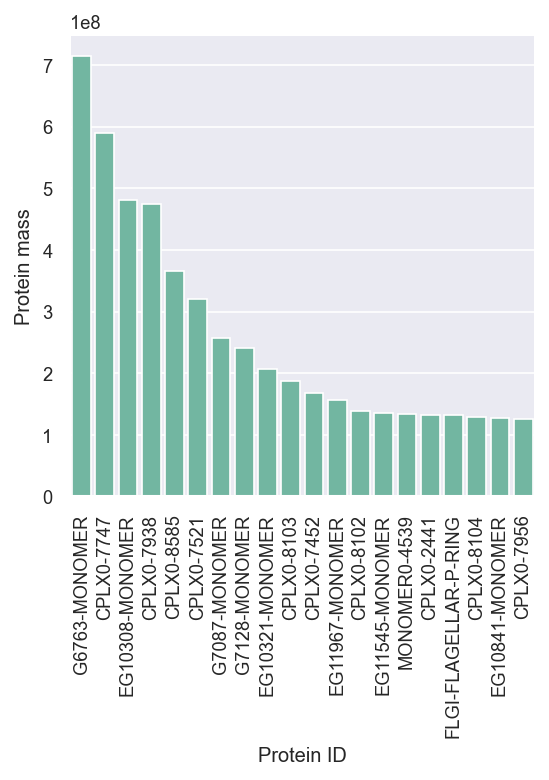

In [23]:
uncategorized_vec = (csr_matrix(np.diag(resources[-1, :].toarray().flatten())) @ Pw)[:, list(pathway_ids).index("Uncategorized (II)")]


# convert to dataframe
uncategorized_df = pl.DataFrame(uncategorized_vec.toarray(), schema=["Protein mass"])

# add protein ID column
uncategorized_df = uncategorized_df.with_columns(pl.DataFrame(protein_ids, schema=["Protein ID"]))

# sort and get top 20, then plot
uncategorized_df = uncategorized_df.sort("Protein mass", descending=True).head(20)

plt.figure(figsize=(4, 4))
sns.barplot(data=uncategorized_df.to_pandas(), x="Protein ID", y="Protein mass", color=sns.color_palette("Set2")[0])

plt.xticks(rotation=90)

## Fe/Zn generalist vs specialist

In [24]:
elements = ["FE", "ZN", "MN", "CU", "MO", "NI", "CO"]
element_indices = [np.where(element_ids == element)[0][0] for element in elements]

median_count = csr_matrix(np.diag(np.median(total_counts_min, axis=0)))

ep_counts = median_count @ C @ P @ E[:, element_indices]

# convert to dataframe
ep_df = pl.DataFrame(ep_counts.toarray(), schema=elements)

# add protein_ids as a column
ep_df = ep_df.with_columns(pl.DataFrame(protein_ids, schema=["Protein"]))

# melt to long form
ep_df = ep_df.melt(id_vars="Protein", value_name="Metal atoms allocated to protein", variable_name="Element")

# remove all rows with 0 atoms/cell
ep_df = ep_df.filter(pl.col("Metal atoms allocated to protein") > 0)

# Get the sum per element
sum_df = ep_df.group_by("Element").agg(pl.sum("Metal atoms allocated to protein").alias("Total atoms"))

# Join with ep_df to get the percentage
ep_df = ep_df.join(sum_df, on="Element")

# calculate the percentage
ep_df = ep_df.with_columns( (ep_df["Metal atoms allocated to protein"] / ep_df["Total atoms"]).alias("Fraction of metal"))

# sort by element, then by fraction of metal
ep_df = ep_df.sort(["Element", "Fraction of metal"], descending=[False, True])

# get the index per row
ep_df = ep_df.with_columns(pl.DataFrame(np.arange(1, ep_df.shape[0]+1), schema=["Index"]))

# groupby element and get minimum index
min_index = ep_df.group_by("Element").agg(pl.min("Index").alias("Min index"))

# join with ep_df, then subtract min index from index
ep_df = ep_df.join(min_index, on="Element")
ep_df = ep_df.with_columns( (ep_df["Index"] - ep_df["Min index"] + 1).alias("Rank"))
ep_df = ep_df.drop(["Min index", "Index"])

# Create cumulative sum of fraction of metal
cumsum_col = ep_df.select(pl.col('Fraction of metal').cumsum().over('Element'))

# add column to ep_df
ep_df = ep_df.with_columns(cumsum_col)

# rename fraction of metal to cumulative fraction of metal
ep_df = ep_df.rename({"Fraction of metal": "Cumulative fraction of metal"})

ep_df

Protein,Element,Metal atoms allocated to protein,Total atoms,Cumulative fraction of metal,Rank
str,str,f64,f64,f64,i64
"""HOMOCYSMETB12-MONOMER""","""CO""",494.0,500.0,0.988,1
"""CPLX0-7741""","""CO""",6.0,500.0,1.0,2
"""CYT-O-UBIOX-CPLX""","""CU""",6986.0,12643.0,0.552559,1
"""EG12318-MONOMER""","""CU""",3344.0,12643.0,0.817053,2
"""G7014-MONOMER""","""CU""",1963.0,12643.0,0.972317,3
…,…,…,…,…,…
"""GALACTURIDYLYLTRANS-MONOMER""","""ZN""",1.0,234414.0,0.999983,214
"""IMIDPHOSPHADEHYDHISTIDPHOSPHA-…","""ZN""",1.0,234414.0,0.999987,215
"""G7055-MONOMER""","""ZN""",1.0,234414.0,0.999991,216


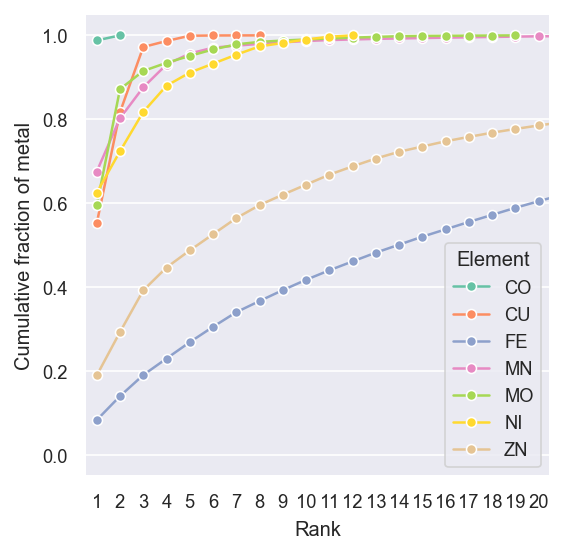

In [25]:
# plot fraction of metal against rank
plt.figure(figsize=(4, 4))
g = sns.lineplot(data=ep_df.to_pandas(), x="Rank", y="Cumulative fraction of metal", hue="Element", marker="o")
plt.xlim(0.5, 20.5)
plt.ylim(-0.05, 1.05)
plt.xticks(np.arange(1, 21, 1))
g.xaxis.grid(False)

<Axes: xlabel='Metal atoms allocated to protein', ylabel='Proportion'>

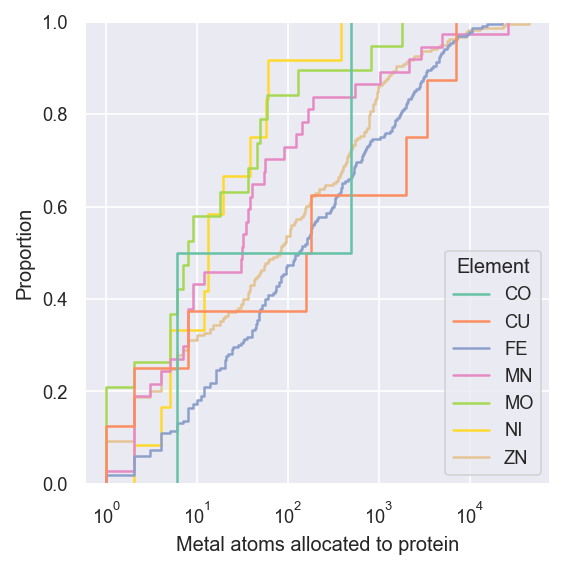

In [26]:
plt.figure(figsize=(4, 4))
sns.ecdfplot(data=ep_df.to_pandas(), x="Metal atoms allocated to protein", hue="Element", complementary=False, log_scale=True)

## Cell iron is mostly in iron-sulfur clusters

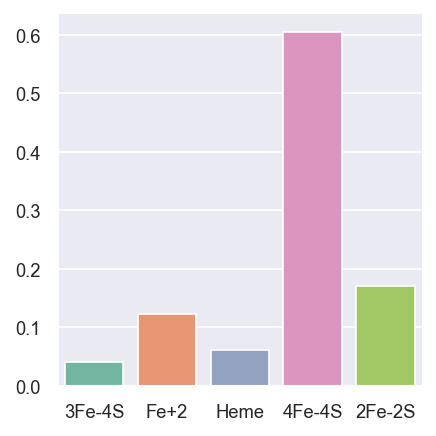

In [27]:
plot_names = {'3FE-4S': '3Fe-4S', 'FE+2': 'Fe+2', 'Heme-b': 'Heme', 'CPD-7': '4Fe-4S', 'CPD-6':'2Fe-2S'}

elements = ["FE"]
element_indices = [np.where(element_ids == element)[0][0] for element in elements]

# find cofactors that use iron
cofactor_iron_stoich = E[:, element_indices].toarray().flatten()

# cofactor names
cofactor_names = np.array(cofactor_ids)[cofactor_iron_stoich > 0]
cofactor_names = [plot_names.get(name, name) for name in cofactor_names]

# compute the distribution across forms of iron
median_count = csr_matrix(np.median(total_counts_min, axis=0))
ep_counts = np.multiply((median_count @ C @ P)[:, cofactor_iron_stoich>0].toarray(), cofactor_iron_stoich[cofactor_iron_stoich>0])

# divide by sum
ep_counts = ep_counts / ep_counts.sum(axis=1)

# create dataframe
ep_df = pl.DataFrame(ep_counts, schema=cofactor_names)

# make plot
sns.catplot(data=ep_df.to_pandas(), kind="bar", aspect=1, height=3)

## # Compare different real bulk data sets

# Story 1: 

## Barplot of the top 50 zinc proteins instead of sankey

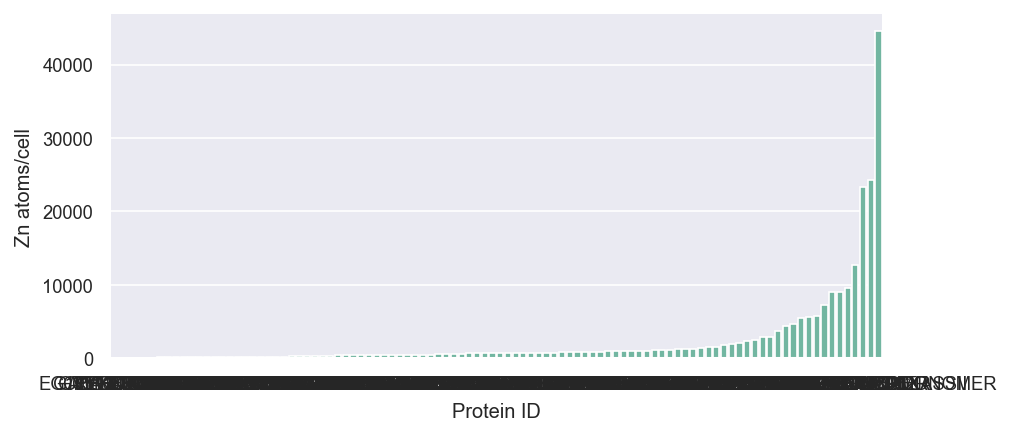

In [28]:
elements = ["ZN"]

element_indices = [np.where(element_ids == element)[0][0] for element in elements]

count_vec = total_counts_min[int(total_counts_min.shape[0]/2), :]

zn_protein = np.diag(count_vec) @ C @ P @ E[:, element_indices]

# argsort the vector
top_50_proteins = np.argsort(zn_protein.flatten())[-100:]

# get protein names
protein_names = [protein_ids[i] for i in top_50_proteins]

# get the counts
protein_counts = [zn_protein[i][0] for i in top_50_proteins]

# make df
pl.DataFrame([protein_counts, protein_names], schema=["Zn atoms/cell", "Protein ID"])

# make a barplot
sns.catplot(data=pl.DataFrame([protein_counts, protein_names], schema=["Zn atoms/cell", "Protein ID"]).to_pandas(), 
            x="Protein ID", y="Zn atoms/cell", kind="bar", aspect=2, height=3)

# Li et al data

In [29]:
li = pl.read_csv("external_data/Li_2014_profiling.csv")
li


Gene,MOPS complete,MOPS minimal,MOPS complete without methionine
str,i64,i64,i64
"""aaeA""",62,5,21
"""aaeB""",16,2,0
"""aaeR""",203,79,141
"""aaeX""",28,5,11
"""aas""",188,80,162
…,…,…,…
"""zraR""",98,30,50
"""zraS""",8,4,0
"""zupT""",407,217,295


In [30]:

name_df = pl.read_csv("external_data/ecocyc_name_conversion.txt", separator="\t")
name_df

Proteins,Genes,Accession-1 of Gene,Common-Name
str,str,str,str
"""LYSU-CPLX""","""EG10553""","""b4129""","""lysU"""
"""EG11817-MONOMER""","""EG11817""","""b2744""","""umpG"""
"""MONOMER0-4534""","""G6577""","""b1120""","""cobB"""
"""FDOI-MONOMER""","""EG11856""","""b3892""","""fdoI"""
"""G6991-MONOMER""","""G6991""","""b1807""","""tsaB"""
…,…,…,…
"""G7835-MONOMER""","""G7835""","""b4145""","""yjeJ"""
"""GALACTITOLPDEHYD-MONOMER""","""EG12417""","""b2091""","""gatD"""
"""EG10736-MONOMER""","""EG10736""","""b0708""","""phr"""


In [31]:
li_df = li.join(name_df, left_on="Gene", right_on="Common-Name")
li_df

Gene,MOPS complete,MOPS minimal,MOPS complete without methionine,Proteins,Genes,Accession-1 of Gene
str,i64,i64,i64,str,str,str
"""lysU""",1644,315,768,"""LYSU-CPLX""","""EG10553""","""b4129"""
"""cobB""",827,572,666,"""MONOMER0-4534""","""G6577""","""b1120"""
"""fdoI""",221,16,13,"""FDOI-MONOMER""","""EG11856""","""b3892"""
"""add""",724,265,548,"""ADENODEAMIN-MONOMER""","""EG10030""","""b1623"""
"""rplN""",118153,18836,79079,"""EG10875-MONOMER""","""EG10875""","""b3310"""
…,…,…,…,…,…,…
"""yjeJ""",45,19,71,"""G7835-MONOMER""","""G7835""","""b4145"""
"""gatD""",643,2360,465,"""GALACTITOLPDEHYD-MONOMER""","""EG12417""","""b2091"""
"""phr""",21,37,5,"""EG10736-MONOMER""","""EG10736""","""b0708"""


In [32]:
# make a list where for each name in monomer_ids,  the corresponding counts in MOPS minimal from li is inserted
# if not found, insert 0
li_counts = [li_df.filter(pl.col("Proteins") == protein)[0, "MOPS complete"] if len(li_df.filter(pl.col("Proteins") == protein)) > 0 else 0 for protein in monomer_ids]
li_counts_min = [li_df.filter(pl.col("Proteins") == protein)[0, "MOPS minimal"] if len(li_df.filter(pl.col("Proteins") == protein)) > 0 else 0 for protein in monomer_ids]
li_counts_met = [li_df.filter(pl.col("Proteins") == protein)[0, "MOPS complete without methionine"] if len(li_df.filter(pl.col("Proteins") == protein)) > 0 else 0 for protein in monomer_ids]


li_counts = np.array(li_counts).flatten().astype(int)
li_counts_min = np.array(li_counts_min).flatten().astype(int)
li_counts_met = np.array(li_counts_met).flatten().astype(int)

# save to csv 
np.savetxt('data/li_counts.csv', np.array(li_counts, dtype=np.int64), delimiter=',', fmt='%i')
np.savetxt('data/li_counts_min.csv', np.array(li_counts_min, dtype=np.int64), delimiter=',', fmt='%i')
np.savetxt('data/li_counts_met.csv', np.array(li_counts_min, dtype=np.int64), delimiter=',', fmt='%i')

In [33]:
elements = ["FE", "ZN"]
element_indices = [np.where(element_ids == element)[0][0] for element in elements]

M = (P @ E[:, element_indices]).toarray()

# make a new array. For each column of M, multiply it elementwise by the li_counts vector
for i in range(M.shape[1]):
    M[:, i] = np.multiply(M[:, i], li_counts_met)

# create polars dataframe. cols are elements, rows are protein_ids
M_df = pl.DataFrame(M, schema=elements)

# add protein_ids as a column
M_df = M_df.with_columns(pl.DataFrame(monomer_ids, schema=["Protein ID"]))

# melt to long form
M_df = M_df.melt(id_vars="Protein ID", value_name="Atoms/cell", variable_name="Element")

In [34]:
# plot top 20 proteins using iron
top_20_proteins = M_df.filter(pl.col("Element") == "ZN").sort(by="Atoms/cell", descending=True).head(20)

top_20_proteins

Protein ID,Element,Atoms/cell
str,str,i64
"""HOMOCYSMET-MONOMER""","""ZN""",282818
"""G7061-MONOMER""","""ZN""",100140
"""ZNUA-MONOMER""","""ZN""",57733
"""FRUCTBISALD-CLASSII-MONOMER""","""ZN""",30954
"""RPOC-MONOMER""","""ZN""",20760
…,…,…
"""ILES-MONOMER""","""ZN""",4760
"""PD00260""","""ZN""",4625
"""CARBOXYL-TRANSFERASE-BETA-MONO…","""ZN""",4611


In [35]:
M_df.filter((pl.col("Element") == "ZN") & (pl.col("Atoms/cell") > 0))

Protein ID,Element,Atoms/cell
str,str,i64
"""ACETYLORNDEACET-MONOMER""","""ZN""",628
"""ADENODEAMIN-MONOMER""","""ZN""",548
"""ADHC-MONOMER""","""ZN""",3116
"""ADHP-MONOMER""","""ZN""",42
"""ALAS-MONOMER""","""ZN""",5773
…,…,…
"""UDPACYLGLCNACDEACETYL-MONOMER""","""ZN""",3773
"""USHA-MONOMER""","""ZN""",926
"""YHHO-MONOMER""","""ZN""",36


## Create comparison plot between methionine and dropout

In [36]:
cofactor_ids

array(['PYRIDOXAL_PHOSPHATE', 'LIPOIC-ACID', '3FE-4S', 'ZN+2',
       'THIAMINE-PYROPHOSPHATE', 'FMN', 'Any+2', 'NA+', 'MG+2', 'FE+2',
       'MN+2', 'Heme-b', 'CPD-8123', 'BIOTIN', 'CA+2', 'COB-I-ALAMIN',
       'CPD-7', 'CPD-6', 'CPD-3', 'L-SELENOCYSTEINE', 'NI+2', 'K+',
       'CO+2', 'CU+2', 'FAD'], dtype='<U22')

In [37]:
cofactors = ["ZN+2"]
cofactor_indices = [np.where(cofactor_ids == cofactor)[0][0] for cofactor in cofactors]

# get indices of Zn-containing proteins
zn_protein_mask = P[:, cofactor_indices].toarray().flatten() > 0 

# get all ribosome proteins
ribosome_id = ['CPLX0-3964']
ribosome_indices = [np.where(protein_ids == protein)[0][0] for protein in ribosome_id]
ribosome_protein_mask = C[ribosome_indices, :].toarray().flatten() > 0

# nonstandard ribosomal protein
nonstandard_ribosome_id = ['G6167-MONOMER','MONOMER0-2656', ]
nonstandard_ribosome_indices = [np.where(monomer_ids == protein)[0][0] for protein in nonstandard_ribosome_id]
nonstandard_ribosome_protein_mask = np.zeros(len(monomer_ids), dtype=bool)
nonstandard_ribosome_protein_mask[nonstandard_ribosome_indices] = True

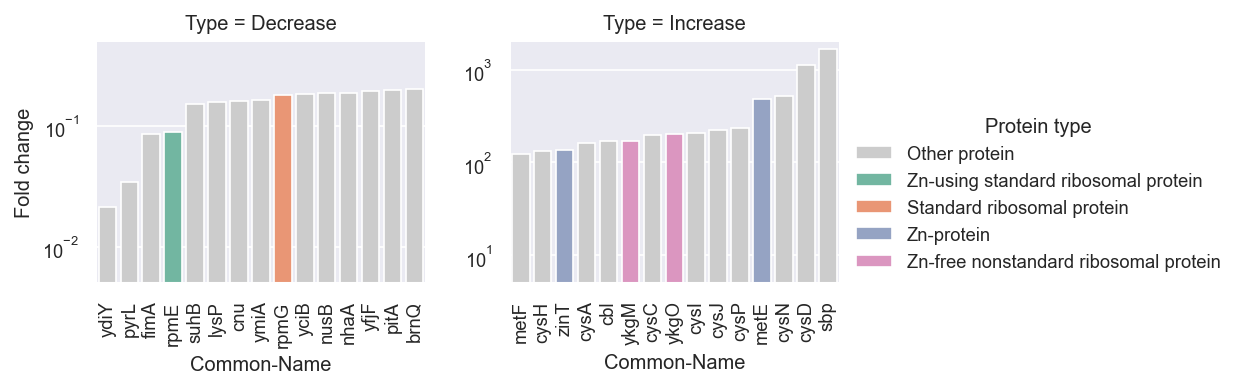

In [38]:
# create dataframe with the counts
li_df = pl.DataFrame([li_counts, li_counts_met, monomer_ids, zn_protein_mask, ribosome_protein_mask, nonstandard_ribosome_protein_mask], 
                     schema=["Complete", "Methionine", "Protein ID", "Uses Zn", "Ribosomal protein", "Nonstandard ribosomal protein"])

# create new conditional column. If both Uses Zn and Ribosomal protein are true, then "Ribosomal protein with Zn"
li_df = li_df.with_columns(pl.lit("N/A").alias("Protein type"))

# iterate over rows
for i in range(li_df.shape[0]):
    if li_df[i, "Uses Zn"] and li_df[i, "Ribosomal protein"]:
        li_df[i, "Protein type"] = "Zn-using standard ribosomal protein"
    elif li_df[i, "Uses Zn"]:
        li_df[i, "Protein type"] = "Zn-protein"
    elif li_df[i, "Ribosomal protein"]:
        li_df[i, "Protein type"] = "Standard ribosomal protein"
    elif li_df[i, "Nonstandard ribosomal protein"]:
        li_df[i, "Protein type"] = "Zn-free nonstandard ribosomal protein"
    else:
        li_df[i, "Protein type"] = "Other protein"


# join with name df to get common names
li_df = li_df.join(name_df, left_on="Protein ID", right_on="Proteins")

# drop rows where both complete and methionine are <1000
li_df = li_df.filter((pl.col("Complete") > 1000) | (pl.col("Methionine") > 1000))
# li_df = li_df.filter((pl.col("Complete") > 200) & (pl.col("Methionine") > 200))


reg = 10
# calculate fold change from complete to methionine
li_df = li_df.with_columns( ((li_df["Methionine"] + reg) / (li_df["Complete"] + reg)).alias("Fold change"))

# sort by fold change
li_df = li_df.sort("Fold change", descending=False)

# make new df with just head and tail
n = 15
li_df_head = li_df.head(n).with_columns(pl.lit("Decrease").alias("Type"))
li_df_tail = li_df.tail(n).with_columns(pl.lit("Increase").alias("Type"))
# concat
li_df_short = pl.concat([li_df_head, li_df_tail])

# create a palette with 5 colors. 1 Gray, then 4 Set2 colors
palette = ["#CCCCCC"] + sns.color_palette("Set2")

# plot log fold change against protein id
g = sns.catplot(data=li_df_short.to_pandas(), x="Common-Name", hue="Protein type", dodge=False,
                y="Fold change", kind="bar", aspect=1.2, height=2.5, col="Type", sharex=False,  sharey=False, palette=palette)

# convert to log scale
g.set(yscale="log")

# change second subplot y limits to 10 to 1000
g.axes[0,0].set_ylim(0.005, 0.5)
g.axes[0,1].set_ylim(5, 2000)


# rotate labels
g.set_xticklabels(rotation=90)

## Growth rate data

In [39]:
gr = pl.read_csv("data/growth_rate_processed.csv")

# rename slope to Growth rate
gr = gr.rename({"slope": "Growth rate (1/hr)", "doubling_time": "Doubling time (h)", "doubling_time_min": "Doubling time (min)"})

# Only keep columns Additive, Replicate, Growth rate
gr = gr.select("Additive", "Growth rate (1/hr)")

gr.head()


Additive,Growth rate (1/hr)
str,f64
"""B12""",1.118869
"""B12""",1.060833
"""B12""",1.102755
"""Zn""",1.068039
"""Zn""",1.102385


In [40]:
# get mean of growth rate for met
met_mean = gr.filter(pl.col("Additive") == "met").mean().select("Growth rate (1/hr)")

# add a column with met_mean as the value
gr = gr.with_columns(pl.lit(met_mean).alias("Mean growth rate (1/hr)"))

# calculate growth rate decrease from mean
gr = gr.with_columns( ((gr["Growth rate (1/hr)"] / gr["Mean growth rate (1/hr)"])).alias("Growth rate defect"))

(0.8, 1.05)

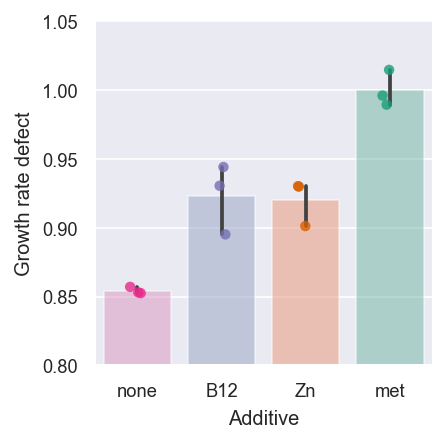

In [41]:
hue_order = ["met", "Zn", "B12", "none"]
order = ["none", "B12", "Zn", "met"]
g = sns.catplot(data=gr.to_pandas(), x="Additive", y="Growth rate defect", hue="Additive",
                kind="bar", aspect=1, height=3, alpha=0.5, hue_order=hue_order, order=order)

g.map_dataframe(sns.stripplot, x="Additive", y="Growth rate defect", alpha=0.8, 
                dodge=False, jitter=0.1, size=5, hue="Additive", palette="Dark2",edgecolor='black', 
                linewidth=0, hue_order=hue_order, order=order,)

plt.ylim(0.8, 1.05)

In [42]:
# get the raw data and raw linear data
r_gr = pl.read_csv("data/growth_rate_raw.csv")
l_gr = pl.read_csv("data/growth_rate_raw_linear.csv")


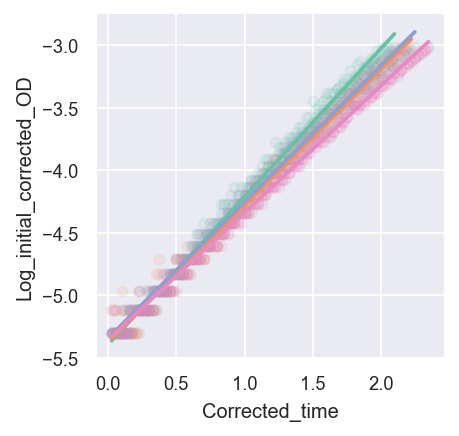

In [43]:
sns.lmplot(x="Corrected_time", y="Log_initial_corrected_OD", hue="Additive", 
           # col_wrap=4,  \
           # hue_order=["none", "Zn", "B12", "met"],
           height=3,aspect=1.05, legend=False,
           data=l_gr.to_pandas(), scatter_kws = {"alpha": 0.1}, hue_order=hue_order)

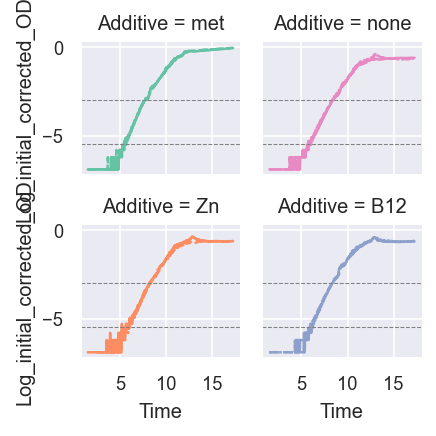

In [44]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    sns.relplot(x="Time", y="Log_initial_corrected_OD", hue="Additive", kind="line", col="Additive", style="Replicate", 
                height=1.5, \
                col_wrap=2, 
                data=r_gr.to_pandas(), legend=False, hue_order=hue_order)
    
# plot horizontal lines at y=-2
for ax in plt.gcf().axes:
    ax.axhline(-3, color='grey', linewidth=0.5, linestyle='--')
    ax.axhline(-5.5, color='grey', linewidth=0.5, linestyle='--')

# Timeseries stability of aggregate molecules

In [45]:
elements = ["ZN"]
element_indices = [np.where(element_ids == element)[0][0] for element in elements]

# compute the timeseries for the elements
element_vec = C @ P @ E[:, element_indices]

# multiply rows of total_counts by element_vec
total_counts_zn = total_counts.copy()

for i in range(total_counts_zn.shape[0]):
    total_counts_zn[i, :] = np.multiply(total_counts_zn[i, :], element_vec.toarray().flatten())
    
# eliminate columns with all zeros
filter_cols = np.any(total_counts_zn, axis=0)
total_counts_zn_filter = total_counts_zn[:, filter_cols]

# index protein ids by filter_cols
protein_ids_filter = protein_ids[filter_cols]

In [46]:
# create a dataframe with the timeseries
total_counts_zn_df = pl.DataFrame(total_counts_zn_filter, schema=protein_ids_filter.tolist())

# add timestep column
total_counts_zn_df = total_counts_zn_df.with_columns(pl.DataFrame(np.arange(0, total_counts_zn_df.shape[0]), schema=["Timestep"]))

# melt to long form
total_counts_zn_df_m = total_counts_zn_df.melt(value_name="Atoms/cell", variable_name="Protein ID", id_vars="Timestep")

# for each protein, find value with timestep 0
initial_values = total_counts_zn_df_m.filter(pl.col("Timestep") == 0)

# alias the column to avoid confusion
initial_values = initial_values.with_columns(pl.col("Atoms/cell").alias("Initial Atoms/cell"))

# join with the original dataframe
total_counts_zn_df_m = total_counts_zn_df_m.join(initial_values, on="Protein ID", how="left")

# filter out proteins with initial atoms/cell less than 100
total_counts_zn_df_m = total_counts_zn_df_m.filter(pl.col("Initial Atoms/cell") > 20)

# calculate the fold change
total_counts_zn_df_m = total_counts_zn_df_m.with_columns( ((total_counts_zn_df_m["Atoms/cell"] +0)/ (total_counts_zn_df_m["Initial Atoms/cell"] +0)).alias("Fold change since t=0"))

# create a sum_df from total_counts_zn_df
sum_df = total_counts_zn_df_m.group_by("Timestep").agg(pl.sum("Atoms/cell").alias("Total atoms"))

# divide sum_df Total atoms by the initial value
sum_df = sum_df.with_columns( (sum_df["Total atoms"] / sum_df.filter(pl.col("Timestep") == 0)["Total atoms"][0]).alias("Fold change since t=0"))

<Axes: xlabel='Timestep', ylabel='Fold change since t=0'>

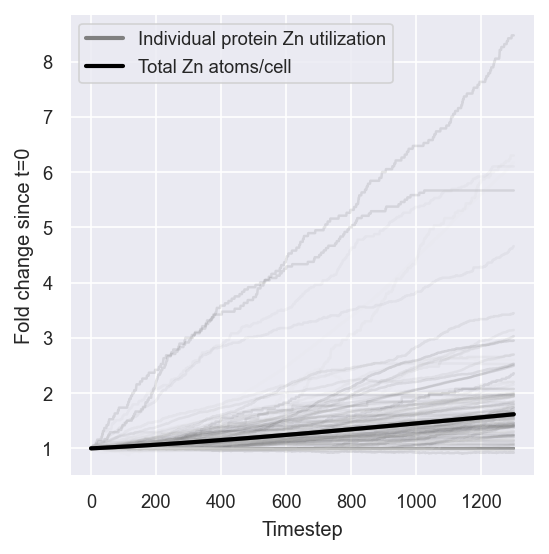

In [47]:
plt.figure(figsize=(4,4))

# plot timeseries for all proteins in a single big chart
sns.lineplot(data=total_counts_zn_df_m.to_pandas(), x="Timestep", y="Fold change since t=0", hue="Protein ID", legend=False, alpha=0.1, palette="gray")

# plot the sum as a thicker line
sns.lineplot(data=sum_df.to_pandas(), x="Timestep", y="Fold change since t=0", color="grey", linewidth=2, label="Individual protein Zn utilization")
sns.lineplot(data=sum_df.to_pandas(), x="Timestep", y="Fold change since t=0", color="black", linewidth=2, label="Total Zn atoms/cell")

(0.0, 220.7)

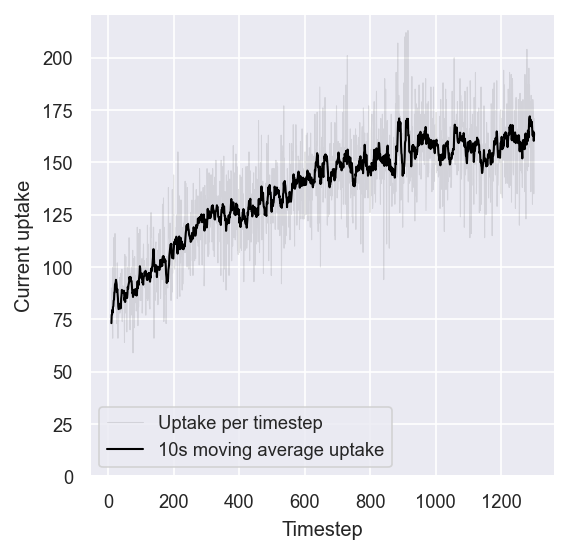

In [48]:
plt.figure(figsize=(4,4))

uptake_df = sum_df.sort(by="Timestep")

# per timestep, calculate the difference from the previous timestep in atoms/cell
uptake_df = uptake_df.with_columns( (uptake_df["Total atoms"] - uptake_df["Total atoms"].shift(1)).alias("Current uptake"))

# do a 5 row moving average of the current uptake
uptake_df = uptake_df.with_columns( (uptake_df["Current uptake"].rolling_mean(window_size=10)).alias("Moving average (10s)"))

# drop rows with null values in current uptake
uptake_df = uptake_df.filter(pl.col("Moving average (10s)").is_not_null())


# plot current uptake
sns.lineplot(data=uptake_df.to_pandas(), x="Timestep", y="Current uptake", color="black", linewidth=0.5, alpha=0.1, label="Uptake per timestep")
sns.lineplot(data=uptake_df.to_pandas(), x="Timestep", y="Moving average (10s)", color="black", linewidth=1, label="10s moving average uptake")

plt.ylim(0, None)

In [49]:
total_counts_zn_df

# select columns with a minimum larger than 100
total_counts_zn_df_s = total_counts_zn_df.select(pl.all().min() > 500)
include = {k: v[0] for k,v in total_counts_zn_df_s.to_dict(as_series=False).items()}
include = [k for k,v in include.items() if v][0:7]

# select columns where total_counts_zn_df_pruned is true
total_counts_zn_df_pruned = total_counts_zn_df.select(include)

# calculate the difference from previous step
diff_df = total_counts_zn_df_pruned.with_columns( (total_counts_zn_df_pruned - total_counts_zn_df_pruned.shift(1)))
                                     
# melt
diff_df = diff_df.with_columns(pl.DataFrame(np.arange(0, diff_df.shape[0]), schema=["Timestep"]))

diff_df = diff_df.melt(value_name="Uptake per protein", variable_name="Protein ID", id_vars="Timestep")
diff_df = diff_df.with_columns( (diff_df["Uptake per protein"].rolling_mean(window_size=20)).alias("Moving average (10s)"))

diff_df                                                                         

Timestep,Protein ID,Uptake per protein,Moving average (10s)
i64,str,i64,f64
0,"""ACETYL-COA-CARBOXYLTRANSFER-CP…",null,null
1,"""ACETYL-COA-CARBOXYLTRANSFER-CP…",0,null
2,"""ACETYL-COA-CARBOXYLTRANSFER-CP…",0,null
3,"""ACETYL-COA-CARBOXYLTRANSFER-CP…",2,null
4,"""ACETYL-COA-CARBOXYLTRANSFER-CP…",0,null
…,…,…,…
1296,"""CPLX0-1101""",0,1.05
1297,"""CPLX0-1101""",0,1.05
1298,"""CPLX0-1101""",0,1.05


<Axes: xlabel='Timestep', ylabel='Moving average (10s)'>

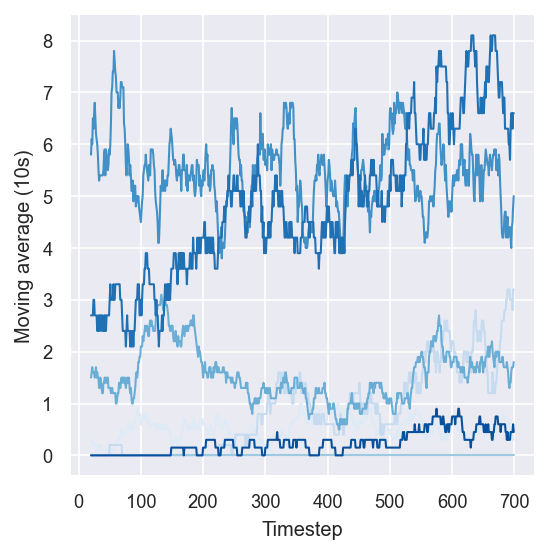

In [50]:
plt.figure(figsize=(4, 4))

# filter timestep to be between 0 and 200
diff_df = diff_df.filter(pl.col("Timestep") < 700)

# sns.lineplot(data=diff_df.to_pandas(), x="Timestep", y="Uptake per protein", hue="Protein ID", legend=False, alpha=1, linewidth=2, palette="gray")
sns.lineplot(data=diff_df.to_pandas(), x="Timestep", y="Moving average (10s)", hue="Protein ID", legend=False, alpha=1, linewidth=1, palette="Blues")


## Transporter mean and noise

<Axes: >

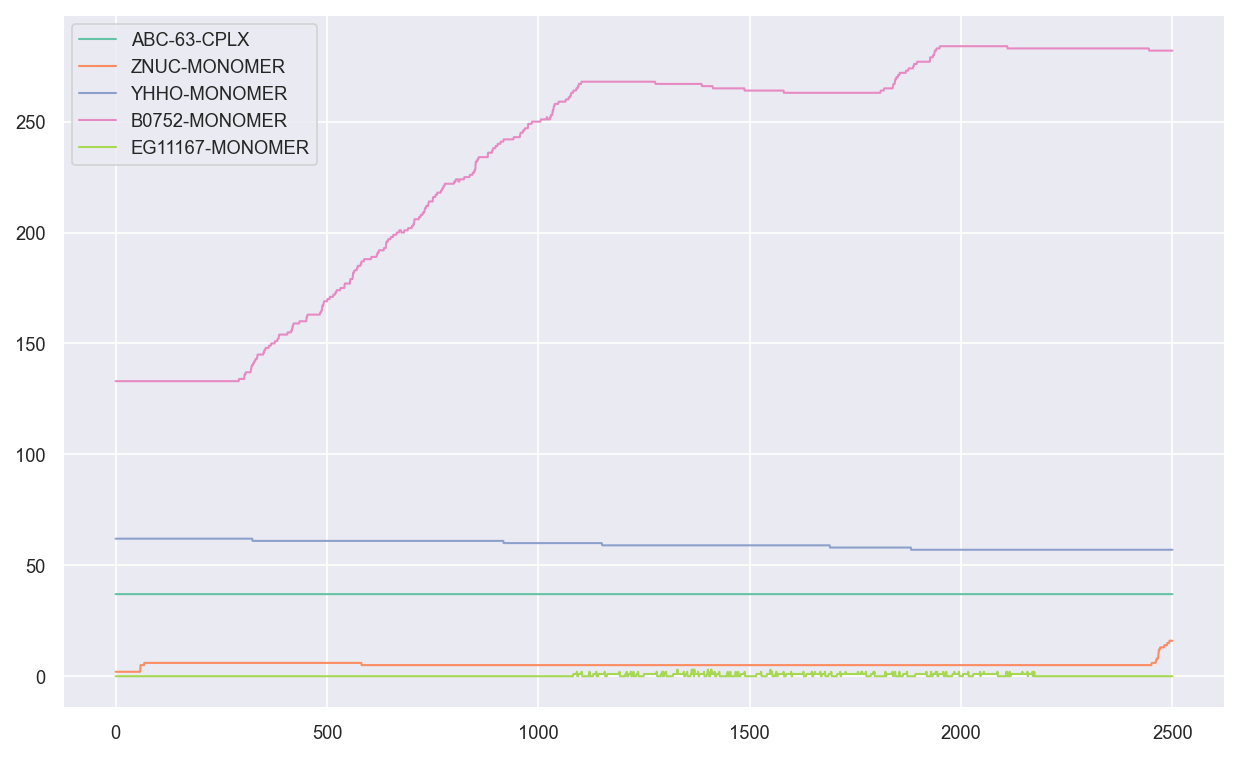

In [51]:
transporter_IDs = ['ABC-63-CPLX', 'ZNUC-MONOMER', 'YHHO-MONOMER', 'B0752-MONOMER', 'EG11167-MONOMER']

# find the indices of the transporters
ts_idx = [np.where(protein_ids == transporter)[0][0] for transporter in transporter_IDs]


# make df
ts_df = pl.DataFrame(total_counts_min[:, ts_idx], schema=transporter_IDs)

# plot timeseries
plt.figure(figsize=(10, 6))
sns.lineplot(data=ts_df.to_pandas(), dashes=False, linewidth=1)

In [52]:
ts_df.std()

ABC-63-CPLX,ZNUC-MONOMER,YHHO-MONOMER,B0752-MONOMER,EG11167-MONOMER
f64,f64,f64,f64,f64
0.0,1.227438,1.768864,53.705981,0.533774


In [53]:
total_counts_zn_df

# select columns with a minimum larger than 100
total_counts_zn_df_s = total_counts_zn_df.select(pl.all().min() > 500)
include = {k: v[0] for k,v in total_counts_zn_df_s.to_dict(as_series=False).items()}
include = [k for k,v in include.items() if v][0:10]

# select columns where total_counts_zn_df_pruned is true
total_counts_zn_df_pruned = total_counts_zn_df.select(include)

# calculate the difference from previous step
diff_df = total_counts_zn_df_pruned.with_columns( (total_counts_zn_df_pruned - total_counts_zn_df_pruned.shift(1)))
                                     
# melt
diff_df = diff_df.with_columns(pl.DataFrame(np.arange(0, diff_df.shape[0]), schema=["Timestep"]))

diff_df = diff_df.melt(value_name="Uptake per protein", variable_name="Protein ID", id_vars="Timestep")
diff_df = diff_df.with_columns( (diff_df["Uptake per protein"].rolling_mean(window_size=20)).alias("Moving average (10s)"))

diff_df                                                                         

Timestep,Protein ID,Uptake per protein,Moving average (10s)
i64,str,i64,f64
0,"""ACETYL-COA-CARBOXYLTRANSFER-CP…",null,null
1,"""ACETYL-COA-CARBOXYLTRANSFER-CP…",0,null
2,"""ACETYL-COA-CARBOXYLTRANSFER-CP…",0,null
3,"""ACETYL-COA-CARBOXYLTRANSFER-CP…",2,null
4,"""ACETYL-COA-CARBOXYLTRANSFER-CP…",0,null
…,…,…,…
1296,"""CPLX0-3001""",0,1.4
1297,"""CPLX0-3001""",0,1.4
1298,"""CPLX0-3001""",4,1.4


<Axes: xlabel='Timestep', ylabel='Moving average (10s)'>

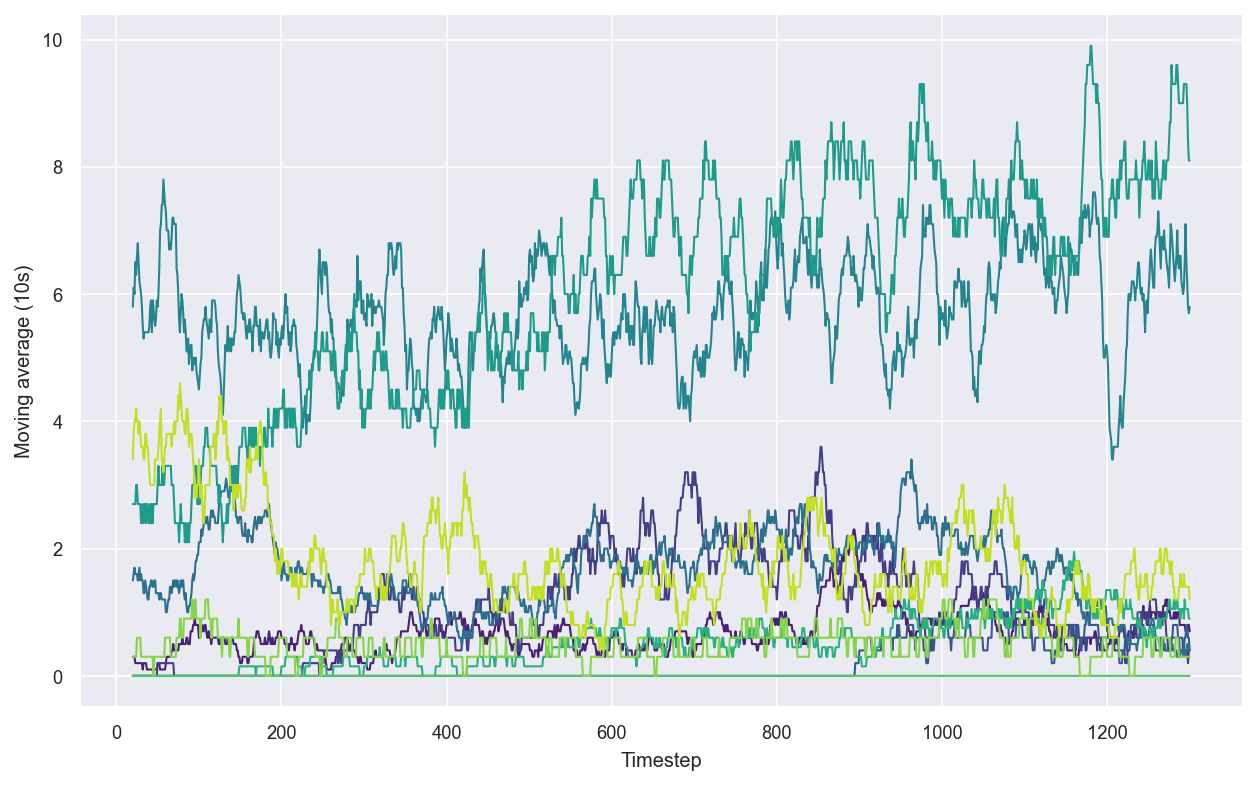

In [54]:
plt.figure(figsize=(10, 6))

# sns.lineplot(data=diff_df.to_pandas(), x="Timestep", y="Uptake per protein", hue="Protein ID", legend=False, alpha=1, linewidth=2, palette="gray")
sns.lineplot(data=diff_df.to_pandas(), x="Timestep", y="Moving average (10s)", hue="Protein ID", legend=False, alpha=1, linewidth=1, palette="viridis")


# Figure 5, improvement of growth media 

In [55]:
# create total counts modified

# find NARG-MONOMER, NARH-MONOMER, NARI-MONOMER and NITRATREDUCTA-CPLX
nitrate_proteins = ['NARG-MONOMER', 'NARH-MONOMER', 'NARI-MONOMER', 'NITRATREDUCTA-CPLX']

# repeat for FDNG-MONOMER, FDNH-MONOMER, FDNI-MONOMER and FORMATEDEHYDROGN-CPLX
formate_proteins = ['FDNG-MONOMER', 'FDNH-MONOMER', 'FDNI-MONOMER', 'FORMATEDEHYDROGN-CPLX']

# find the indices of the proteins
nitrate_idx = [np.where(protein_ids == protein)[0][0]+1 for protein in nitrate_proteins]
formate_idx = [np.where(protein_ids == protein)[0][0]+1 for protein in formate_proteins]

# create modified counts where the nitrate proteins are multiplied by 100
total_counts_mod = total_counts_big.copy()
total_counts_mod[:, nitrate_idx] = total_counts_mod[:, nitrate_idx] * 1000

# repeat bulk calculation
elements = ["FE", "ZN", "MN", "CU", "MO", "NI", "CO"]
element_indices = [np.where(element_ids == element)[0][0] for element in elements]

# compute the timeseries for the elements
big_element_timeseries = total_counts_mod[:, 1:-1] @ C @ P @ E[:, element_indices]

# convert to polars dataframe
big_element_df = pl.DataFrame(big_element_timeseries, schema=elements)

# add Timestep and Cell index from total_counts_big 
big_element_df = big_element_df.with_columns(pl.DataFrame(total_counts_mod[:, [0, -1]], schema=["Timestep", "Cell index"]))
big_element_df

# Groupby cell index, then add the max timestep for each cell
max_timestep = big_element_df.group_by("Cell index").agg(pl.col("Timestep").max().alias("Max timestep"))

# merge with original
big_element_df = big_element_df.join(max_timestep, on="Cell index")

# calculate cell density correction factor with 2 ^((Max timestep - Timestep)/Max timestep)
big_element_df = big_element_df.with_columns( (2 ** ((big_element_df["Max timestep"] - big_element_df["Timestep"]) 
                                                     / big_element_df["Max timestep"])).alias("Density correction"))

# remove all cols except element, cell index and density correction
big_element_df = big_element_df.drop(["Timestep", "Max timestep"])

# multiply the atoms/cell by the density correction
big_element_df = big_element_df.melt(id_vars=["Cell index", "Density correction"], value_name="Atoms/cell", variable_name="Element")

# Get the weighted average per element
big_element_df = big_element_df.with_columns( (big_element_df["Atoms/cell"] * big_element_df["Density correction"]).alias("Weighted atoms/cell"))

# divide sum of weighted atoms/cell by sum of density correction
bulk_element_sum = big_element_df.group_by(["Element", "Cell index"]).agg(pl.sum("Weighted atoms/cell").alias("Sum weighted atoms/cell"))
bulk_element_count = big_element_df.group_by(["Element", "Cell index"]).agg(pl.sum("Density correction").alias("Sum density correction"))

# join the two dataframes and divide
bulk_element_df = bulk_element_sum.join(bulk_element_count, on=["Element", "Cell index"])
bulk_element_df = bulk_element_df.with_columns( (bulk_element_df["Sum weighted atoms/cell"] / bulk_element_df["Sum density correction"]).alias("Bulk atoms/cell"))

# remove other cols
bulk_element_df = bulk_element_df.drop(["Sum weighted atoms/cell", "Sum density correction"])

# save to csv
bulk_element_df.write_csv("data/sim_rich_bulk_element_df.csv", include_header=True)

# calculate avg and std dev over all cells
bulk_element_mod_avg = bulk_element_df.group_by("Element").agg(pl.mean("Bulk atoms/cell").alias("Avg atoms/cell"), pl.std("Bulk atoms/cell").alias("Std atoms/cell"))

# add two rows: V and CR with 0 atoms/cell. Concat them to bulk_element_avg
bulk_element_mod_avg = pl.concat([bulk_element_mod_avg, pl.DataFrame([["V", 0., 0.], ["CR", 0., 0.]], schema=["Element", "Avg atoms/cell", "Std atoms/cell"])])

# set "CO" to 0
bulk_element_mod_avg = bulk_element_mod_avg.with_columns(pl.when(pl.col("Element") == "CO").then(0).otherwise(pl.col("Avg atoms/cell")).alias("Avg atoms/cell"))
bulk_element_mod_avg = bulk_element_mod_avg.with_columns(pl.when(pl.col("Element") == "CO").then(0).otherwise(pl.col("Std atoms/cell")).alias("Std atoms/cell"))

# rename cols to match other df
bulk_element_mod_avg = bulk_element_mod_avg.rename({"Element": "Element", "Avg atoms/cell": "Atoms/cell (simulation)", "Std atoms/cell": "Atoms/cell (simulation), stddev"})

bulk_element_mod_avg

Element,Atoms/cell (simulation),"Atoms/cell (simulation), stddev"
str,f64,f64
"""ZN""",358309.796049,17700.748347
"""CO""",0.0,0.0
"""NI""",1349.451218,202.649004
"""MN""",70715.579385,3175.616962
"""MO""",26932.184348,23107.459043
"""FE""",861940.885177,450534.663234
"""CU""",19175.295716,1318.540353
"""V""",0.0,0.0
"""CR""",0.0,0.0


In [56]:
bulk_element_avg

Element,Atoms/cell (simulation),"Atoms/cell (simulation), stddev"
str,f64,f64
"""NI""",1349.451218,202.649004
"""MO""",3642.138596,346.19631
"""MN""",70715.579385,3175.616962
"""FE""",439779.010905,24899.6101
"""ZN""",358309.796049,17700.748347
"""CU""",19175.295716,1318.540353
"""CO""",0.0,0.0
"""V""",0.0,0.0
"""CR""",0.0,0.0


<Axes: xlabel='Condition', ylabel='Atoms/cell (simulation)'>

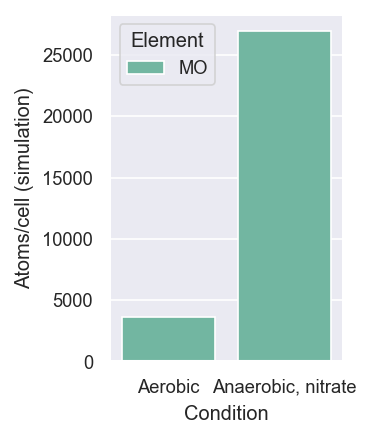

In [57]:
# concat bulk_element_avg and bulk_element_mod_avg, add new column "Condition"
bulk_element_avg = bulk_element_avg.with_columns(pl.lit("Aerobic").alias("Condition"))
bulk_element_mod_avg = bulk_element_mod_avg.with_columns(pl.lit("Anaerobic, nitrate").alias("Condition"))

bulk_element_concat = pl.concat([bulk_element_avg, bulk_element_mod_avg])

# filter only mo
bulk_element_concat = bulk_element_concat.filter(pl.col("Element") == "MO")

# plot 
plt.figure(figsize=(2, 3))
sns.barplot(data=bulk_element_concat.to_pandas(), x="Condition", y="Atoms/cell (simulation)", hue="Element")

In [87]:
# copy ez_df
mops_df = ez_df.clone()
lb_df = media_lim_df.clone()

# for ez_df, in the condition column, replace Minimal with "MOPS Minimal" and Rich with "EZ Rich". use the replace method in polars.
# first select the condition column, then use the replace method
new_col = mops_df.get_column("Condition").map_dict({"Minimal": "MOPS Minimal", "Rich": "EZ Rich"})
mops_df = mops_df.with_columns(new_col)

new_col = lb_df.get_column("Condition").map_dict({"Minimal": "Minimal media (A)", "Rich": "LB"})
lb_df = lb_df.with_columns(new_col)

# filter out minimal media
mops_df = mops_df.filter((pl.col("Condition") != "MOPS Minimal") )
lb_df = lb_df.filter((pl.col("Condition") != "Minimal media (A)"))

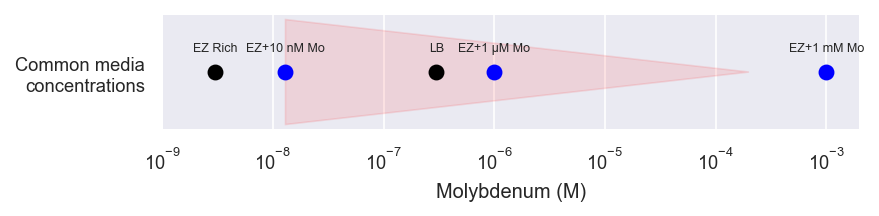

In [109]:

order_pts = ["EZ+10 nM Mo", "EZ+1 µM Mo", "EZ+1 mM Mo", "EZ Rich", "LB"]

mo_lb_df = lb_df.filter(pl.col("Element") == "MO").select("Condition", "Element", "Concentration (M)")
mo_ez_df = mops_df.filter(pl.col("Element") == "MO").select("Condition", "Element", "Concentration (M)")

# rename col to Molybdenum (M)
mo_lb_df = mo_lb_df.rename({"Concentration (M)": "Molybdenum (M)"})
mo_ez_df = mo_ez_df.rename({"Concentration (M)": "Molybdenum (M)"})

# concatenate the two dataframes
mo_df = pl.concat([mo_lb_df, mo_ez_df])


# concat a new df with the following concentrations: 10 nm, 1 µm, 1 mM
mo_df = pl.concat([mo_df, pl.DataFrame({"Condition": ["EZ+10 nM Mo", "EZ+1 µM Mo", "EZ+1 mM Mo"], 
                                        "Element": ["MO", "MO", "MO"], 
                                        "Molybdenum (M)": [1e-8 + 3e-9, 1e-6, 1e-3],})])

# multiply concentration by N_A and divide by 1 trillion cells/ml at OD 1
mo_df = mo_df.with_columns( (mo_df["Molybdenum (M)"] * 6.022e23 / 1e12).alias("Molybdenum (atoms/cell)"))


# 1d line plot with concentrations
f, axs = plt.subplots(1,1,  figsize=(6,1))

sns.pointplot(data=mo_df.to_pandas(), hue="Condition", x="Molybdenum (M)", 
              marker="o", legend=False, ax=axs, hue_order=order_pts, 
              markersize=6, palette=["blue", "blue", "blue",  "black", "black", ], )

# change x minimum 
axs.set_xlim(1e-9, 2e-3)

axs.set_xscale("log")
# remove xticklabels
axs.set_xticklabels([])
axs.set_yticklabels(["Common media\nconcentrations"])
# write the name of the condition above each point
for i, txt in enumerate(mo_df["Condition"]):
    axs.annotate(txt, (mo_df["Molybdenum (M)"][i] , mo_df["Molybdenum (M)"][i] - 1e-1), fontsize=6, ha="center")

# add a transparent rectangle that stretches from 300 nM to 1 µM
# axs.axvspan(xmin=1.5e-9, xmax=2e-8, ymin=0.25, ymax=0.75, color='blue', alpha=0.1)
#sns.pointplot(data=mo_df.to_pandas(), hue="Condition", x="Concentration (M)", marker="o", legend=False, palette="viridis", ax=ax[1], alpha=0)
axs.set_xscale("log")
axs.set_xticklabels([])

# set yticklabel to be "aerobic conditions"
# ax[1].set_yticklabels(["Cell requirement:\nAerobic respiration"])


# second plot
# axs.axvspan(xmin=5e-8, xmax=2e-6, ymin=0.25, ymax=0.75, color='red', alpha=0.1)

# make a triangle, with the following vertices. (1e-7, 0.5), (1e-6, 0.75), (1e-6, 0.25)
axs.fill([1.3e-8, 1.3e-8, 2e-4], [-0.25, 0.25, 0.], color='red', alpha=0.1)


#sns.pointplot(data=mo_df.to_pandas(), hue="Condition", x="Concentration (M)", marker="o", legend=False, palette="viridis", ax=ax[2], alpha=0)
axs.set_xscale("log")
# ax[2].set_yticklabels(["Cell requirement:\nAnaerobic nitrate\nrespiration"])



## Updated data

In [119]:
# order = ["-/-", "+/-", "+/1", "+/2", "+/3"]

mapping = {"-/-": "No nitrate", "+/-": "Base media", "+/1": "10 nM Mo", 
           "+/2": "1 µM Mo", "+/3": "1 mM Mo"}

values = list(mapping.values())

# import the data
mo_gr_df = pl.read_csv("data/no3_df_v2.csv")

# drop -/2 rows
mo_gr_df = mo_gr_df.filter(pl.col("Additive") != "-/2")


order = list(mapping.values())

# replace the Additive column with the mapping
mo_gr_df = mo_gr_df.with_columns(mo_gr_df.get_column("Additive").map_dict(mapping))

# Map Molybdenum to these values in a new column: -: 3 nm, 1: 10 nm, 2: 1 µM, 3: 1 mM
mo_gr_df = mo_gr_df.with_columns(mo_gr_df.get_column("Molybdenum").map_dict({"-": 3e-9, "1": 1.3e-8, "2": 1e-6, "3": 1e-3}).alias("Molybdenum (M)"))

# drop null values
mo_gr_df = mo_gr_df.filter(pl.col("Additive").is_not_null())

# Create a growth rate change column. Subtract mean of base, then divide by mean of base
mo_gr_df = mo_gr_df.with_columns( ((mo_gr_df["Growth rate"] - mo_gr_df.filter(pl.col("Additive") == "Base media")["Growth rate"].mean()) / mo_gr_df.filter(pl.col("Additive") == "Base media")["Growth rate"].mean()).alias("Growth rate change"))

# multiply by 100
mo_gr_df = mo_gr_df.with_columns( (mo_gr_df["Growth rate change"] * 100).alias("Growth rate change (%)"))

mo_gr_df

Additive,Growth rate,Nitrate,Molybdenum,Molybdenum (M),Growth rate change,Growth rate change (%)
str,f64,str,str,f64,f64,f64
"""Base media""",1.582207,"""+""","""-""",3.0000e-9,0.018575,1.857508
"""Base media""",1.552509,"""+""","""-""",3.0000e-9,-0.000543,-0.054334
"""Base media""",1.564273,"""+""","""-""",3.0000e-9,0.00703,0.702988
"""Base media""",1.51512,"""+""","""-""",3.0000e-9,-0.024614,-2.461381
"""Base media""",1.579022,"""+""","""-""",3.0000e-9,0.016525,1.652473
…,…,…,…,…,…,…
"""No nitrate""",1.138065,"""-""","""-""",3.0000e-9,-0.26735,-26.734964
"""No nitrate""",1.185643,"""-""","""-""",3.0000e-9,-0.23672,-23.672031
"""No nitrate""",1.213204,"""-""","""-""",3.0000e-9,-0.218978,-21.897757


(1e-09, 0.002)

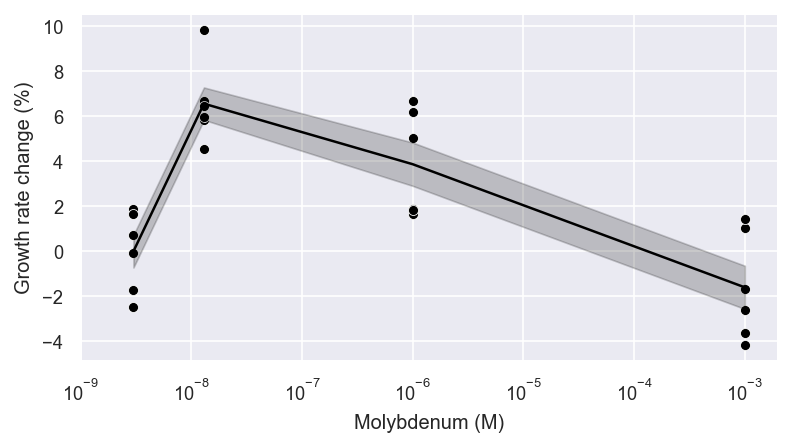

In [120]:
order = ["Base media", "10 nM Mo", "1 µM Mo", "1 mM Mo"]

# scatter mo_gr_df 
f = plt.figure(figsize=(6, 3))
sns.scatterplot(data=mo_gr_df.filter(pl.col("Additive") != "No nitrate").to_pandas(), 
                x="Molybdenum (M)", y="Growth rate change (%)",  legend=False, color="black")

# scatter means of the different conditions
sns.lineplot(data=mo_gr_df.filter(pl.col("Additive") != "No nitrate").to_pandas(),
                x="Molybdenum (M)", y="Growth rate change (%)",  palette="viridis",   legend=False, color="black", errorbar="se")

plt.xscale("log")

plt.xlim(1e-9, 2e-3)

## Old version

In [60]:
# order = ["-/-", "+/-", "+/1", "+/2", "+/3"]

mapping = {"-/-": "No nitrate", "+/-": "Base media", "+/1": "10 nM Mo", 
           "+/2": "1 µM Mo", "+/3": "1 mM Mo"}

values = list(mapping.values())

# import the data
mo_gr_df = pl.read_csv("data/no3_df.csv")

# drop -/2 rows
mo_gr_df = mo_gr_df.filter(pl.col("Additive") != "-/2")


order = list(mapping.values())

# replace the Additive column with the mapping
mo_gr_df = mo_gr_df.with_columns(mo_gr_df.get_column("Additive").map_dict(mapping))

# Map Molybdenum to these values in a new column: -: 3 nm, 1: 10 nm, 2: 1 µM, 3: 1 mM
mo_gr_df = mo_gr_df.with_columns(mo_gr_df.get_column("Molybdenum").map_dict({"-": 3e-9, "1": 1.3e-8, "2": 1e-6, "3": 1e-3}).alias("Molybdenum (M)"))

mo_gr_df

Additive,Growth rate,Nitrate,Molybdenum,Molybdenum (M)
str,f64,str,str,f64
"""Base media""",1.250401,"""+""","""-""",3.0000e-9
"""Base media""",1.332296,"""+""","""-""",3.0000e-9
"""Base media""",1.17367,"""+""","""-""",3.0000e-9
"""10 nM Mo""",1.317036,"""+""","""1""",1.3000e-8
"""10 nM Mo""",1.367509,"""+""","""1""",1.3000e-8
…,…,…,…,…
"""1 mM Mo""",1.467211,"""+""","""3""",0.001
"""1 mM Mo""",1.369507,"""+""","""3""",0.001
"""No nitrate""",1.033564,"""-""","""-""",3.0000e-9


(1e-09, 0.002)

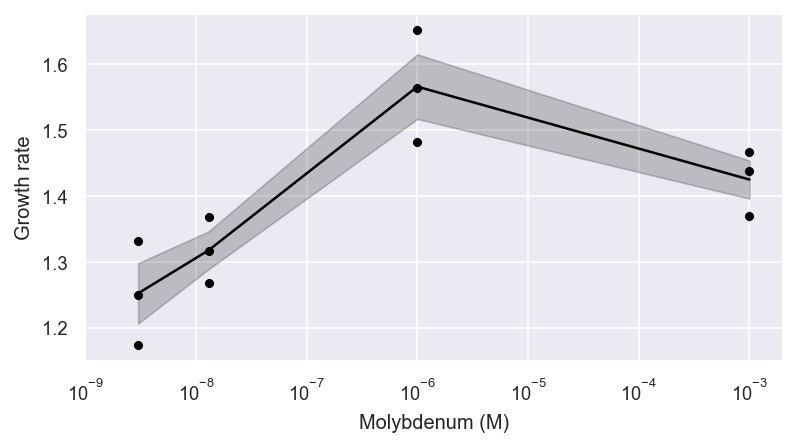

In [61]:
order = ["Base media", "10 nM Mo", "1 µM Mo", "1 mM Mo"]

# scatter mo_gr_df 
f = plt.figure(figsize=(6, 3))
sns.scatterplot(data=mo_gr_df.filter(pl.col("Additive") != "No nitrate").to_pandas(), 
                x="Molybdenum (M)", y="Growth rate",  legend=False, color="black")

# scatter means of the different conditions
sns.lineplot(data=mo_gr_df.filter(pl.col("Additive") != "No nitrate").to_pandas(),
                x="Molybdenum (M)", y="Growth rate",  palette="viridis",   legend=False, color="black", errorbar="se")

plt.xscale("log")

plt.xlim(1e-9, 2e-3)

# Comparison to aerobic growth

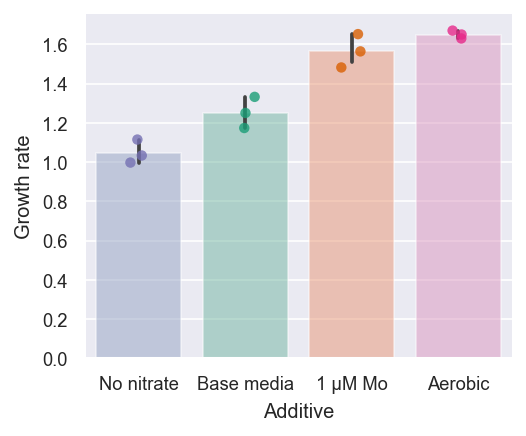

In [63]:
groups = ["No nitrate", "Base media","1 µM Mo"]

filter_mo = mo_gr_df.filter(pl.col("Additive").is_in(groups)).select("Additive", "Growth rate")

# add a row with a growth rate of 1.6
filter_mo = pl.concat([filter_mo, pl.DataFrame([["Aerobic", 1.65], 
                                                ["Aerobic", 1.67],
                                                ["Aerobic", 1.63]], schema=["Additive", "Growth rate"])])

order = ["No nitrate", "Base media", "1 µM Mo", "Aerobic"]

# plot filter df
# f = plt.figure(figsize=(6, 3))  
g = sns.catplot(data=filter_mo.to_pandas(), x="Additive", y="Growth rate", hue="Additive", legend=False,
            order=order, kind="bar", aspect=1.2, height=3, alpha=0.5,)

g.map_dataframe(sns.stripplot, x="Additive", y="Growth rate", alpha=0.8, 
                dodge=False, jitter=0.1, size=5, hue="Additive", palette="Dark2",edgecolor='black', linewidth=0, order=order)

(0.0, 1.8)

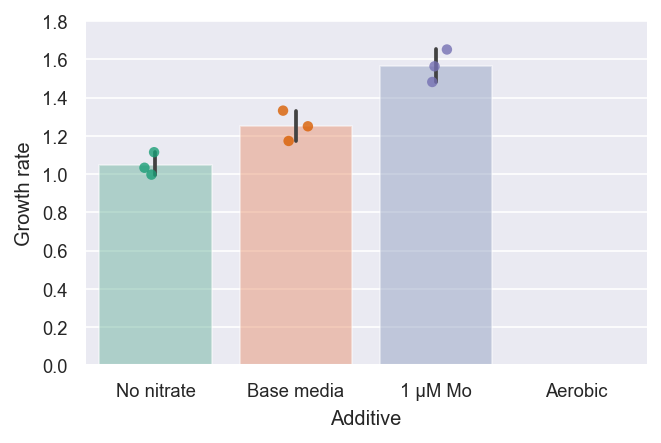

In [64]:


g = sns.catplot(data=mo_gr_df.to_pandas(), x="Additive", y="Growth rate", hue="Additive",
                kind="bar", aspect=1.5, height=3, alpha=0.5, hue_order=order, order=order)

g.map_dataframe(sns.stripplot, x="Additive", y="Growth rate", alpha=0.8, 
                dodge=False, jitter=0.1, size=5, hue="Additive", palette="Dark2",edgecolor='black', linewidth=0, hue_order=order, order=order)

plt.ylim(0, 1.8)